# **Modélisation par régression de crête**

**API SKL** : [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)

**Guide SKL** : [**Ridge regression and classification** (1.1.2)](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification)

**Résout** : $\min_{w} || X w - y||_2^2 + \alpha ||w||_2^2$

**Complexité** : $\mathcal{O}(n p^2)$ ~ complexité OLS.

## Chargement et nettoyage des données

In [1]:
from pepper_commons import get_data
from seattle_commons import clean_dataset, drop_my_outliers
data = get_data()                                    # load data from CSV file
data, not_compliant, outliers = clean_dataset(data)  # drop outliers identified by Seattle
data, my_outliers = drop_my_outliers(data)           # drop my own outliers (18)

✔ _data loaded
✔ struct loaded


## Partition *résidentiel* vs. *non résidentiel*

In [2]:
from seattle_commons import get_family_buildings, get_business_buildings
r_data = get_family_buildings(data)                # residential subset
nr_data = get_business_buildings(data)             # non residential subset

# Expérimentation

## Config 1 : $e = f(a)$

Ensemble minimal.

$\{a : e\}$

Sous-performance par rapport à l'OLS de :
* ... pour la recherche en grille avec `GridSearchCV`,
* ... pour la recherche intégrée avec `RidgeCV`.

C'est assez surprenant pour supposer que la `RidgeCV` a été mal utilisée.

$R^2_{1, \text{Ridge}} \left(\{a : g\}\right)$ :
* $\mu = 0.2164046897083014$
* $\sigma = 0.15658879256851746$

$R^2_{1, \text{RidgeCV}} \left(\{a : g\}\right)$ :
* $\mu = 0.13318310394532948$
* $\sigma = 0.29300881135227325$

Rappel pour comparaison :

$R^2_{1, \text{OLS}} \left(\{a : g\}\right)$ :
* $\mu = 0.2633858597214695$
* $\sigma = 0.16993461331808574$

#### Jeu de données

In [3]:
config_name = "{a : g}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

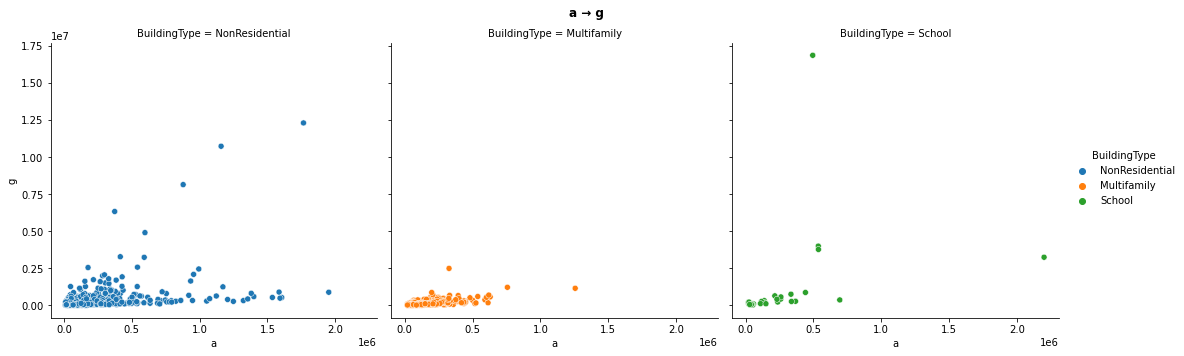

In [4]:
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [5]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [6]:
# Features / target split
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

# Train / test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Entraînement

##### Recherche en grille externe

In [7]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
lr = linear_model.LinearRegression()
lr_reg = lr.fit(X_train, y_train)
baseline_err = cross_val_score(lr_reg, X_train, y_train, cv=5).mean()
print(baseline_err)

-1.5866855140435931


In [8]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_commons import print_title, print_subtitle, bold
import time
from pepper_skl_commons import Dataset, get_baseline_err, search_best_params, get_best_params

Xy = X_train, X_test, y_train, y_test
model = linear_model.Ridge()
param_grid = {
    'alpha': np.logspace(9, 15, 100),
    'solver': ['auto', 'svd', 'sparse_cg', 'sag', 'saga'], # , 'cholesky', 'lsqr', 'lbfgs'
    'random_state': [42]
}

(
    best_estimator,
    best_params,
    best_score,
    best_index,
    scorer,
    cv_res
) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

coucoukookoo


In [9]:
print('best', bold('estimator'), ':', best_estimator)
print('best', bold('params'), ':', best_params)
print('best', bold('score'), ':', best_score)
print('best', bold('index'), ':', best_index)
print(bold('scorer'), ':', scorer)

print(' train', bold('score'), ':', best_estimator.score(X_train, y_train))
print('  test', bold('score'), ':', best_estimator.score(X_test, y_test))
print('global', bold('score'), ':', best_estimator.score(X, y))

print('best', bold('estimator'), 'intercept :', best_estimator.intercept_)
print('best', bold('estimator'), '    coefs :', best_estimator.coef_)

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(best_estimator, X, y, cv=3)

best estimator : Ridge(alpha=35111917342151.418, random_state=42)
best params : {'alpha': 35111917342151.418, 'random_state': 42, 'solver': 'auto'}
best score : 0.22299808361595988
best index : 375
scorer : <function _passthrough_scorer at 0x000001EE031CA790>
 train score : 0.16577591562854443
  test score : 0.11903689791872629
global score : 0.1323227578799
best estimator intercept : 56980.40210890782
best estimator     coefs : [0.6739758]
cv scores : [0.07222946 0.43406085 0.14292376]
mean scores : 0.2164046897083014
std scores : 0.15658879256851746


In [10]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
377,0.003200,0.000749,0.002000,2.570502e-06,35111917342151.417969,42,sparse_cg,"{'alpha': 35111917342151.418, 'random_state': ...",0.144312,0.434097,0.184191,0.305678,0.046712,0.222998,0.134293,1
376,0.002999,0.000002,0.002599,4.891061e-04,35111917342151.417969,42,svd,"{'alpha': 35111917342151.418, 'random_state': ...",0.144312,0.434097,0.184191,0.305678,0.046712,0.222998,0.134293,1
375,0.002999,0.000894,0.002000,7.776979e-07,35111917342151.417969,42,auto,"{'alpha': 35111917342151.418, 'random_state': ...",0.144312,0.434097,0.184191,0.305678,0.046712,0.222998,0.134293,1
378,0.003201,0.000400,0.002201,4.003070e-04,35111917342151.417969,42,sag,"{'alpha': 35111917342151.418, 'random_state': ...",0.144292,0.434059,0.184192,0.305632,0.046714,0.222978,0.134277,4
379,0.003600,0.000490,0.002001,1.183479e-06,35111917342151.417969,42,saga,"{'alpha': 35111917342151.418, 'random_state': ...",0.144336,0.434038,0.184178,0.304838,0.046713,0.222821,0.134169,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.004000,0.000631,0.002400,4.900007e-04,12328467394.420633,42,saga,"{'alpha': 12328467394.420633, 'random_state': ...",0.223905,-0.143472,-0.873980,-7.339575,0.187383,-1.589148,2.902140,496
89,0.003997,0.001096,0.002002,1.998170e-06,10722672220.103254,42,saga,"{'alpha': 10722672220.103254, 'random_state': ...",0.223894,-0.143712,-0.874256,-7.342171,0.187406,-1.589768,2.903133,497
84,0.004200,0.000747,0.002399,4.884262e-04,9326033468.83218,42,saga,"{'alpha': 9326033468.83218, 'random_state': 42...",0.223884,-0.143920,-0.874496,-7.344430,0.187427,-1.590307,2.903996,498
178,0.003403,0.001020,0.001598,4.892852e-04,132194114846.602875,42,sag,"{'alpha': 132194114846.60287, 'random_state': ...",0.224504,-0.134887,-0.872817,-7.362960,0.186944,-1.591843,2.912343,499


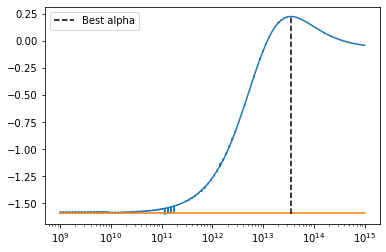

In [11]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(cv_res.param_alpha, cv_res.mean_test_score, [10**9, 10**15], [baseline_err, baseline_err])
ax.set_xscale('log')
ax.vlines(
    best_params["alpha"],
    cv_res.mean_test_score.min(),
    cv_res.mean_test_score.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)
plt.legend()
plt.show()

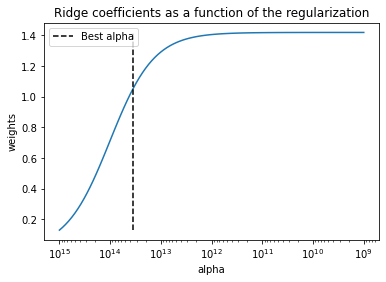

In [12]:
# cf. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html
n_alphas = 100
alphas = np.logspace(9, 15, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

coefs = np.ravel(coefs)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.vlines(
    best_params["alpha"],
    coefs.min(),
    coefs.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.legend()

plt.show()

##### Recherche en grille intégrée

In [13]:
reg = linear_model.RidgeCV(alphas=np.logspace(9, 15, 100))
reg.fit(X_train, y_train)

print('best', bold('alpha'), ':', reg.alpha_)
print('best', bold('n-MSE score'), ':', reg.best_score_)
print(' train', bold('r2 score'), ':', reg.score(X_train, y_train))
print('  test', bold('r2 score'), ':', reg.score(X_test, y_test))
print('global', bold('r2 score'), ':', reg.score(X, y))

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(reg, X, y, cv=15)

# display(reg.cv_values_)


best alpha : 4977023564332.114
best n-MSE score : -256674998703.07825
 train r2 score : 0.27855386453876707
  test r2 score : 0.15012843573396029
global r2 score : 0.18663308148709
cv scores : [ 0.07878826 -0.0692936   0.25569001 -0.08559335  0.05605521  0.53161915
  0.86410126  0.33132186  0.10950796 -0.17063642  0.22927532 -0.44284854
  0.15112228  0.04225186  0.11638531]
mean scores : 0.13318310394532948
std scores : 0.29300881135227325


## Config 4 : passage au log

$\{\log(a):\log(e)\}$

Les performances sont les mêmes que celles de la régression OLS.

$R^2_{4, \text{Ridge}} \left(\{\log(a):\log(g)\}\right)$
* $\mu = 0.3463184882130493$
* $\sigma = 0.06209386400874266$

Rappel pour comparaison :

$R^2_{4, \text{OLS}} \left(\{\log(a) : \log(g)\}\right)$:
* $\mu = 0.3463395572103616$
* $\sigma = 0.06211171186045244$

#### Jeu de données

In [14]:
config_name = "{log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

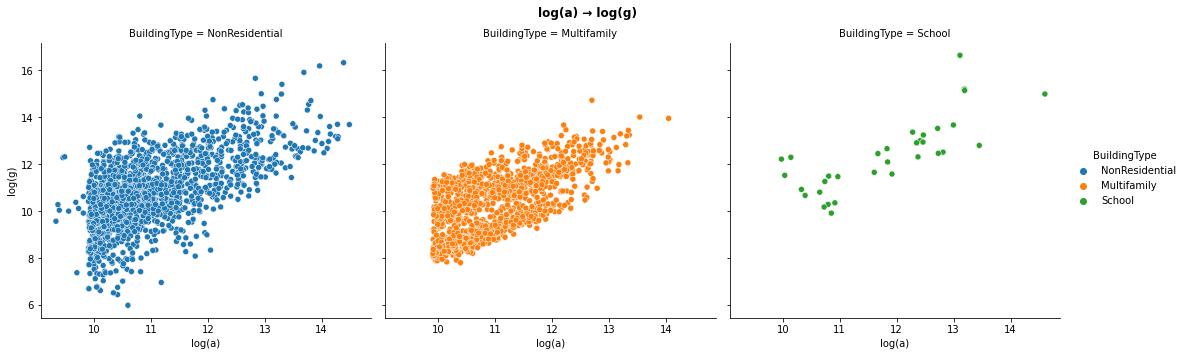

In [15]:
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [16]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [17]:
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Entraînement

##### Recherche en grille externe

In [18]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
lr = linear_model.LinearRegression()
lr_reg = lr.fit(X_train, y_train)
baseline_err = cross_val_score(lr_reg, X_train, y_train, cv=5).mean()
print(baseline_err)

0.381538251244118


In [19]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_commons import print_title, print_subtitle, bold
import time
from pepper_skl_commons import Dataset, get_baseline_err, search_best_params, get_best_params

Xy = X_train, X_test, y_train, y_test
model = linear_model.Ridge()
param_grid = {
    'alpha': np.logspace(-1, 1, 100),
    'solver': ['auto', 'svd', 'sparse_cg', 'sag', 'saga'], # , 'cholesky', 'lsqr', 'lbfgs'
    'random_state': [42]
}

(
    best_estimator,
    best_params,
    best_score,
    best_index,
    scorer,
    cv_res
) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

coucoukookoo


In [20]:
print('best', bold('estimator'), ':', best_estimator)
print('best', bold('params'), ':', best_params)
print('best', bold('score'), ':', best_score)
print('best', bold('index'), ':', best_index)
print(bold('scorer'), ':', scorer)

print(' train', bold('score'), ':', best_estimator.score(X_train, y_train))
print('  test', bold('score'), ':', best_estimator.score(X_test, y_test))
print('global', bold('score'), ':', best_estimator.score(X, y))

print('best', bold('estimator'), 'intercept :', best_estimator.intercept_)
print('best', bold('estimator'), '    coefs :', best_estimator.coef_)

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(best_estimator, X, y, cv=3)

best estimator : Ridge(alpha=4.328761281083059, random_state=42, solver='saga')
best params : {'alpha': 4.328761281083059, 'random_state': 42, 'solver': 'saga'}
best score : 0.38167723326451364
best index : 409
scorer : <function _passthrough_scorer at 0x000001EE031CA790>
 train score : 0.3953468283002508
  test score : 0.3996168566901429
global score : 0.398666190470246
best estimator intercept : -0.9968627865589568
best estimator     coefs : [1.04483267]
cv scores : [0.42652909 0.27562163 0.3365048 ]
mean scores : 0.3462185052981024
std scores : 0.06198941952217611


In [21]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
409,0.003999,0.000631,0.002602,0.000488,4.328761,42,saga,"{'alpha': 4.328761281083059, 'random_state': 4...",0.323642,0.364761,0.382288,0.352456,0.485238,0.381677,0.055197,1
414,0.004199,0.000403,0.002199,0.000399,4.534879,42,saga,"{'alpha': 4.5348785081285845, 'random_state': ...",0.323661,0.364744,0.382275,0.352477,0.485180,0.381667,0.055170,2
419,0.004201,0.000749,0.002400,0.000490,4.75081,42,saga,"{'alpha': 4.750810162102798, 'random_state': 4...",0.323679,0.364726,0.382261,0.352498,0.485119,0.381657,0.055142,3
424,0.003601,0.000490,0.002001,0.000003,4.977024,42,saga,"{'alpha': 4.977023564332112, 'random_state': 4...",0.323699,0.364708,0.382246,0.352521,0.485054,0.381646,0.055112,4
3,0.003592,0.000484,0.001801,0.000400,0.1,42,sag,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.323278,0.363862,0.382531,0.352212,0.486303,0.381637,0.055755,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.005203,0.000750,0.002199,0.000401,1.555676,42,sag,"{'alpha': 1.5556761439304723, 'random_state': ...",0.323428,0.363945,0.382448,0.352234,0.483553,0.381122,0.054684,496
303,0.004801,0.000749,0.002798,0.000400,1.629751,42,sag,"{'alpha': 1.6297508346206444, 'random_state': ...",0.323435,0.363950,0.382444,0.352241,0.483528,0.381120,0.054672,497
308,0.004798,0.000749,0.002401,0.000491,1.707353,42,sag,"{'alpha': 1.7073526474706913, 'random_state': ...",0.323443,0.363956,0.382439,0.352249,0.483501,0.381118,0.054660,498
313,0.005000,0.000001,0.002400,0.000489,1.78865,42,sag,"{'alpha': 1.7886495290574351, 'random_state': ...",0.323450,0.363961,0.382435,0.352257,0.483474,0.381115,0.054647,499


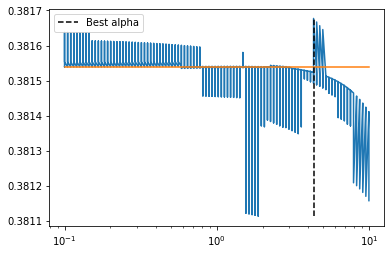

In [22]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(cv_res.param_alpha, cv_res.mean_test_score, [10**-1, 10**1], [baseline_err, baseline_err])
ax.set_xscale('log')
ax.vlines(
    best_params["alpha"],
    cv_res.mean_test_score.min(),
    cv_res.mean_test_score.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)
plt.legend()
plt.show()

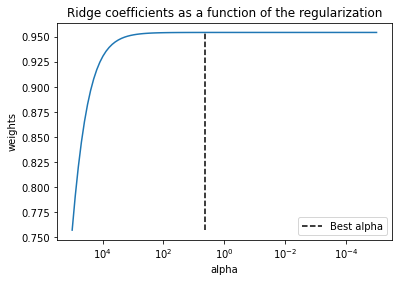

In [23]:
# cf. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html
n_alphas = 100
alphas = np.logspace(-5, 5, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)

coefs = np.ravel(coefs)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.vlines(
    best_params["alpha"],
    coefs.min(),
    coefs.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.legend()

plt.show()

##### Recherche en grille intégrée

In [24]:
reg = linear_model.RidgeCV(alphas=np.logspace(-5, 15, 100)) #, store_cv_values=True)
reg.fit(X_train, y_train)

print('best', bold('alpha'), ':', reg.alpha_)
print('best', bold('n-MSE score'), ':', reg.best_score_)
print(' train', bold('r2 score'), ':', reg.score(X_train, y_train))
print('  test', bold('r2 score'), ':', reg.score(X_test, y_test))
print('global', bold('r2 score'), ':', reg.score(X, y))

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(reg, X, y, cv=3)

# display(reg.cv_values_)


best alpha : 0.7054802310718645
best n-MSE score : -1.2774379719671867
 train r2 score : 0.3953670569392933
  test r2 score : 0.3998107419703608
global r2 score : 0.3988189705231254
cv scores : [0.4268191  0.2756838  0.33645256]
mean scores : 0.3463184882130493
std scores : 0.06209386400874266


## Config. 9 : contribution du score ENERGYSTAR

$\{n_\star, \log(a):\log(g)\}$

Même interprétation que précédemment, le Ridge non pénalisé revient à l'OLS.

$R^2_{9, \text{Ridge}} \left(\{n_\star, \log(a) :\log(g)\}\right)$:
* $\mu = 0.374506552353139$
* $\sigma = 0.06478205141542212$

Rappels pour comparaison :

$R^2_{4, \text{Ridge}} \left(\{\log(a):\log(g)\}\right)$
* $\mu = $
* $\sigma = $

$R^2_{9, \text{OLS}} \left(\{n_\star, \log(a) :\log(g)\}\right)$:
* $\mu = $
* $\sigma = $

$R^2_{4, \text{OLS}} \left(\{\log(a):\log(g)\}\right)$:
* $\mu = $
* $\sigma = $

#### Jeu de données

In [30]:
config_name = "{n_★, log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Vérifications

In [31]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [32]:
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Entraînement

##### Recherche en grille externe

In [33]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
lr = linear_model.LinearRegression()
lr_reg = lr.fit(X_train, y_train)
baseline_err = cross_val_score(lr_reg, X_train, y_train, cv=5).mean()
print(baseline_err)

0.40589806317587146


In [35]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_commons import print_title, print_subtitle, bold
import time
from pepper_skl_commons import Dataset, get_baseline_err, search_best_params, get_best_params

Xy = X_train, X_test, y_train, y_test
model = linear_model.Ridge()
min_alpha_log = -1
max_alpha_log = 1
n_alphas = 100

param_grid = {
    'alpha': np.logspace(min_alpha_log, max_alpha_log, n_alphas),
    'solver': ['auto', 'svd', 'sparse_cg', 'sag', 'saga', 'cholesky', 'lsqr'], #, 'lbfgs'
    'random_state': [42]
}

"""best_estimator = best_params = best_score = best_index = scorer = cv_res = None
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")"""
(
    best_estimator,
    best_params,
    best_score,
    best_index,
    scorer,
    cv_res
) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

coucoukookoo


In [36]:
print('best', bold('estimator'), ':', best_estimator)
print('best', bold('params'), ':', best_params)
print('best', bold('score'), ':', best_score)
print('best', bold('index'), ':', best_index)
print(bold('scorer'), ':', scorer)

print(' train', bold('score'), ':', best_estimator.score(X_train, y_train))
print('  test', bold('score'), ':', best_estimator.score(X_test, y_test))
print('global', bold('score'), ':', best_estimator.score(X, y))

print('best', bold('estimator'), 'intercept :', best_estimator.intercept_)
print('best', bold('estimator'), '    coefs :', best_estimator.coef_)

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(best_estimator, X, y, cv=3)

best estimator : Ridge(alpha=0.1, random_state=42, solver='sag')
best params : {'alpha': 0.1, 'random_state': 42, 'solver': 'sag'}
best score : 0.4059230187213167
best index : 3
scorer : <function _passthrough_scorer at 0x000001EE031CA790>
 train score : 0.4192944704263526
  test score : 0.4264024741513228
global score : 0.4247777035152426
best estimator intercept : -0.4963888105897496
best estimator     coefs : [-0.00938067  1.05847787]
cv scores : [0.45784012 0.30021911 0.36545633]
mean scores : 0.3745051880093695
std scores : 0.06466584451111178


In [37]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.004394,0.001029,0.001599,0.000800,0.1,42,sag,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.352764,0.395436,0.418646,0.362087,0.500682,0.405923,0.052912,1
10,0.005200,0.000748,0.002000,0.000894,0.104762,42,sag,"{'alpha': 0.10476157527896648, 'random_state':...",0.352764,0.395437,0.418645,0.362088,0.500681,0.405923,0.052912,2
17,0.006803,0.001476,0.001795,0.000398,0.10975,42,sag,"{'alpha': 0.10974987654930562, 'random_state':...",0.352765,0.395437,0.418644,0.362089,0.500680,0.405923,0.052911,3
24,0.007605,0.000488,0.002794,0.000401,0.114976,42,sag,"{'alpha': 0.11497569953977356, 'random_state':...",0.352765,0.395437,0.418644,0.362090,0.500679,0.405923,0.052910,4
31,0.006002,0.000002,0.002199,0.000400,0.12045,42,sag,"{'alpha': 0.12045035402587821, 'random_state':...",0.352766,0.395437,0.418643,0.362090,0.500678,0.405923,0.052910,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,0.006804,0.000977,0.001797,0.000399,8.302176,42,saga,"{'alpha': 8.302175681319747, 'random_state': 4...",0.354097,0.395968,0.416918,0.363622,0.497249,0.405571,0.051059,696
676,0.009798,0.001717,0.002801,0.000748,8.69749,42,saga,"{'alpha': 8.697490026177835, 'random_state': 4...",0.354124,0.395974,0.416863,0.363654,0.497147,0.405552,0.051009,697
683,0.009400,0.000804,0.002199,0.000401,9.111628,42,saga,"{'alpha': 9.111627561154895, 'random_state': 4...",0.354152,0.395979,0.416712,0.363686,0.497040,0.405514,0.050953,698
690,0.008199,0.001168,0.001801,0.000401,9.545485,42,saga,"{'alpha': 9.545484566618342, 'random_state': 4...",0.354181,0.395983,0.416652,0.363720,0.496779,0.405463,0.050845,699


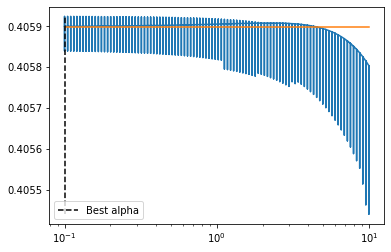

In [38]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(cv_res.param_alpha, cv_res.mean_test_score,
        [10**min_alpha_log, 10**max_alpha_log], [baseline_err, baseline_err])
ax.set_xscale('log')
ax.vlines(
    best_params["alpha"],
    cv_res.mean_test_score.min(),
    cv_res.mean_test_score.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


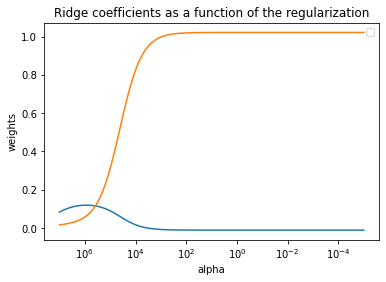

In [39]:
# cf. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html
alphas = np.logspace(-5, 7, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X, y)
    coefs.append(ridge.coef_[0])

#coefs = np.vstack(coefs)
#flat_coefs = np.ravel(coefs)
#display(coefs)


ax = plt.gca()
ax.plot(alphas, coefs)
"""ax.vlines(
    best_params["alpha"],
    #flat_coefs.min(),
    #flat_coefs.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)"""

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.legend()

plt.show()

In [40]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.004394,0.001029,0.001599,0.000800,0.1,42,sag,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.352764,0.395436,0.418646,0.362087,0.500682,0.405923,0.052912,1
10,0.005200,0.000748,0.002000,0.000894,0.104762,42,sag,"{'alpha': 0.10476157527896648, 'random_state':...",0.352764,0.395437,0.418645,0.362088,0.500681,0.405923,0.052912,2
17,0.006803,0.001476,0.001795,0.000398,0.10975,42,sag,"{'alpha': 0.10974987654930562, 'random_state':...",0.352765,0.395437,0.418644,0.362089,0.500680,0.405923,0.052911,3
24,0.007605,0.000488,0.002794,0.000401,0.114976,42,sag,"{'alpha': 0.11497569953977356, 'random_state':...",0.352765,0.395437,0.418644,0.362090,0.500679,0.405923,0.052910,4
31,0.006002,0.000002,0.002199,0.000400,0.12045,42,sag,"{'alpha': 0.12045035402587821, 'random_state':...",0.352766,0.395437,0.418643,0.362090,0.500678,0.405923,0.052910,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,0.006804,0.000977,0.001797,0.000399,8.302176,42,saga,"{'alpha': 8.302175681319747, 'random_state': 4...",0.354097,0.395968,0.416918,0.363622,0.497249,0.405571,0.051059,696
676,0.009798,0.001717,0.002801,0.000748,8.69749,42,saga,"{'alpha': 8.697490026177835, 'random_state': 4...",0.354124,0.395974,0.416863,0.363654,0.497147,0.405552,0.051009,697
683,0.009400,0.000804,0.002199,0.000401,9.111628,42,saga,"{'alpha': 9.111627561154895, 'random_state': 4...",0.354152,0.395979,0.416712,0.363686,0.497040,0.405514,0.050953,698
690,0.008199,0.001168,0.001801,0.000401,9.545485,42,saga,"{'alpha': 9.545484566618342, 'random_state': 4...",0.354181,0.395983,0.416652,0.363720,0.496779,0.405463,0.050845,699


##### Recherche en grille intégrée

In [41]:
reg = linear_model.RidgeCV(alphas=np.logspace(-5, 15, 100)) #, store_cv_values=True)
reg.fit(X_train, y_train)

print('best', bold('alpha'), ':', reg.alpha_)
print('best', bold('n-MSE score'), ':', reg.best_score_)
print(' train', bold('r2 score'), ':', reg.score(X_train, y_train))
print('  test', bold('r2 score'), ':', reg.score(X_test, y_test))
print('global', bold('r2 score'), ':', reg.score(X, y))

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(reg, X, y, cv=3)

# display(reg.cv_values_)


best alpha : 0.7054802310718645
best n-MSE score : -1.2295837468636228
 train r2 score : 0.4193054648321852
  test r2 score : 0.4265469334970059
global r2 score : 0.42489057162325894
cv scores : [0.45798362 0.30007618 0.36545986]
mean scores : 0.374506552353139
std scores : 0.06478205141542212


## Config 12 : réintroduction de `ptype`

$\{t_p, \log(a) : \log(g)\}$

Amélioration négligeable par rapport à la régression OLS.

$R^2_{12, \text{Ridge}} \left(\{t_p, \log(a) : \log(g)\}\right)$ :
* $\mu = 0.4974423402135824$
* $\sigma = 0.06249944065113777$ 

Rappel pour comparaison :

$R^2_{12, \text{OLS}} \left(\{t_p, \log(a) : \log(g)\}\right)$ :
* $\mu = $
* $\sigma = $

#### Jeu de données

In [42]:
config_name = "{t_p, log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Vérifications

In [43]:
from seattle_commons import check_data
check_data(ml_data)

✔ All coefficients are positive or null
✔ No NA coefficient


#### Partition

In [44]:
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Entraînement

##### Recherche en grille externe

In [45]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    lr = linear_model.LinearRegression()
    lr_reg = lr.fit(X_train, y_train)
    baseline_err = cross_val_score(lr_reg, X_train, y_train, cv=5).mean()
    print(baseline_err)

0.47809665924165595


In [46]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_commons import print_title, print_subtitle, bold
import time
from pepper_skl_commons import Dataset, get_baseline_err, search_best_params, get_best_params

Xy = X_train, X_test, y_train, y_test
model = linear_model.Ridge()
min_alpha_log = -1
max_alpha_log = 1
n_alphas = 100

param_grid = {
    'alpha': np.logspace(min_alpha_log, max_alpha_log, n_alphas),
    'solver': ['auto', 'svd', 'sparse_cg', 'sag', 'saga', 'cholesky', 'lsqr'], #, 'lbfgs'
    'random_state': [42]
}

best_estimator = best_params = best_score = best_index = scorer = cv_res = None
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    (
        best_estimator,
        best_params,
        best_score,
        best_index,
        scorer,
        cv_res
    ) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

coucoukookoo


In [47]:
import warnings
with warnings.catch_warnings():
    print('best', bold('estimator'), ':', best_estimator)
    print('best', bold('params'), ':', best_params)
    print('best', bold('score'), ':', best_score)
    print('best', bold('index'), ':', best_index)
    print(bold('scorer'), ':', scorer)

    print(' train', bold('score'), ':', best_estimator.score(X_train, y_train))
    print('  test', bold('score'), ':', best_estimator.score(X_test, y_test))
    print('global', bold('score'), ':', best_estimator.score(X, y))

    print('best', bold('estimator'), 'intercept :', best_estimator.intercept_)
    print('best', bold('estimator'), '    coefs :', best_estimator.coef_)

    from seattle_commons import show_ols_scores # TODO : à renommer
    show_ols_scores(best_estimator, X, y, cv=3)

best estimator : Ridge(alpha=2.25701971963392, random_state=42, solver='sag')
best params : {'alpha': 2.25701971963392, 'random_state': 42, 'solver': 'sag'}
best score : 0.4904724871739174
best index : 472
scorer : <function _passthrough_scorer at 0x000001EE031CA790>
 train score : 0.5360698804334453
  test score : 0.5375834888705893
global score : 0.5372712784515115
best estimator intercept : 0.44880778265406285
best estimator     coefs : [-0.92191792 -0.643846   -0.28131547  0.35402451 -0.64108417 -0.64602182
 -0.37791027  0.03048572 -0.19668177  0.49013344  0.080291   -0.6700335
  0.23925905  0.16361751  0.07550185  1.06057837 -1.13980022 -0.04051762
  0.11060093 -0.12866117  1.18444165  0.74300692  1.15584898  0.95274227]
cv scores : [0.57209895 0.4178961  0.5019115 ]
mean scores : 0.49730218366492757
std scores : 0.06303736477055147


In [48]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
472,0.013799,0.000400,0.003200,0.000401,2.25702,42,sag,"{'alpha': 2.25701971963392, 'random_state': 42...",0.470915,0.458132,0.544150,0.465931,0.513235,0.490472,0.032955,1
479,0.011800,0.001470,0.002200,0.000399,2.364489,42,sag,"{'alpha': 2.3644894126454084, 'random_state': ...",0.470532,0.459250,0.543614,0.465935,0.513017,0.490469,0.032579,2
465,0.010199,0.001601,0.002601,0.000488,2.154435,42,sag,"{'alpha': 2.1544346900318843, 'random_state': ...",0.471281,0.456990,0.544670,0.465923,0.513448,0.490463,0.033339,3
486,0.010801,0.001326,0.003000,0.000002,2.477076,42,sag,"{'alpha': 2.4770763559917115, 'random_state': ...",0.470133,0.460341,0.543065,0.465934,0.512794,0.490454,0.032212,4
470,0.005001,0.000630,0.002799,0.000399,2.25702,42,svd,"{'alpha': 2.25701971963392, 'random_state': 42...",0.470915,0.458106,0.544170,0.465848,0.513192,0.490446,0.032973,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.003200,0.000748,0.002400,0.000488,0.1,42,svd,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.478171,0.390986,0.558476,0.464050,0.510412,0.480419,0.055252,696
5,0.003799,0.000403,0.002199,0.000402,0.1,42,cholesky,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.478171,0.390986,0.558476,0.464050,0.510412,0.480419,0.055252,697
0,0.003401,0.001019,0.001799,0.000398,0.1,42,auto,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.478171,0.390986,0.558476,0.464050,0.510412,0.480419,0.055252,697
13,0.006600,0.000801,0.003199,0.000749,0.104762,42,lsqr,"{'alpha': 0.10476157527896648, 'random_state':...",0.478828,0.388952,0.558064,0.463727,0.512256,0.480365,0.056017,699


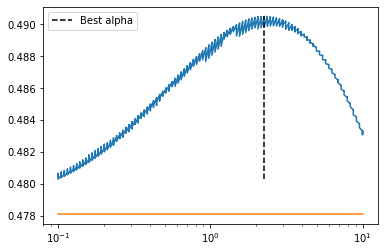

In [49]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(cv_res.param_alpha, cv_res.mean_test_score,
        [10**min_alpha_log, 10**max_alpha_log], [baseline_err, baseline_err])
ax.set_xscale('log')
ax.vlines(
    best_params["alpha"],
    cv_res.mean_test_score.min(),
    cv_res.mean_test_score.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


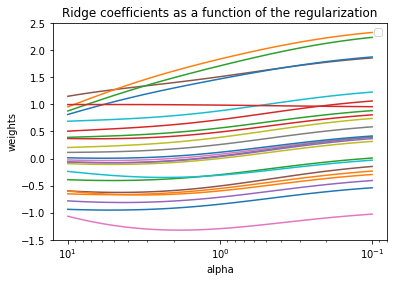

In [50]:
# cf. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html

import warnings
with warnings.catch_warnings():
    alphas = np.logspace(min_alpha_log, max_alpha_log, n_alphas)

    coefs = []
    for a in alphas:
        ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
        ridge.fit(X, y)
        coefs.append(ridge.coef_[0])

    #coefs = np.vstack(coefs)
    #flat_coefs = np.ravel(coefs)
    #display(coefs)


    ax = plt.gca()
    ax.plot(alphas, coefs)
    """ax.vlines(
        best_params["alpha"],
        #flat_coefs.min(),
        #flat_coefs.max(),
        color="black",
        linestyle="--",
        label="Best alpha",
    )"""

    ax.set_xscale("log")
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel("alpha")
    plt.ylabel("weights")
    plt.title("Ridge coefficients as a function of the regularization")
    plt.axis("tight")
    plt.legend()

    plt.show()

In [51]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
472,0.013799,0.000400,0.003200,0.000401,2.25702,42,sag,"{'alpha': 2.25701971963392, 'random_state': 42...",0.470915,0.458132,0.544150,0.465931,0.513235,0.490472,0.032955,1
479,0.011800,0.001470,0.002200,0.000399,2.364489,42,sag,"{'alpha': 2.3644894126454084, 'random_state': ...",0.470532,0.459250,0.543614,0.465935,0.513017,0.490469,0.032579,2
465,0.010199,0.001601,0.002601,0.000488,2.154435,42,sag,"{'alpha': 2.1544346900318843, 'random_state': ...",0.471281,0.456990,0.544670,0.465923,0.513448,0.490463,0.033339,3
486,0.010801,0.001326,0.003000,0.000002,2.477076,42,sag,"{'alpha': 2.4770763559917115, 'random_state': ...",0.470133,0.460341,0.543065,0.465934,0.512794,0.490454,0.032212,4
470,0.005001,0.000630,0.002799,0.000399,2.25702,42,svd,"{'alpha': 2.25701971963392, 'random_state': 42...",0.470915,0.458106,0.544170,0.465848,0.513192,0.490446,0.032973,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.003200,0.000748,0.002400,0.000488,0.1,42,svd,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.478171,0.390986,0.558476,0.464050,0.510412,0.480419,0.055252,696
5,0.003799,0.000403,0.002199,0.000402,0.1,42,cholesky,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.478171,0.390986,0.558476,0.464050,0.510412,0.480419,0.055252,697
0,0.003401,0.001019,0.001799,0.000398,0.1,42,auto,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.478171,0.390986,0.558476,0.464050,0.510412,0.480419,0.055252,697
13,0.006600,0.000801,0.003199,0.000749,0.104762,42,lsqr,"{'alpha': 0.10476157527896648, 'random_state':...",0.478828,0.388952,0.558064,0.463727,0.512256,0.480365,0.056017,699


##### Recherche en grille intégrée

In [52]:
reg = linear_model.RidgeCV(alphas=np.logspace(-5, 15, 100)) #, store_cv_values=True)
reg.fit(X_train, y_train)

print('best', bold('alpha'), ':', reg.alpha_)
print('best', bold('n-MSE score'), ':', reg.best_score_)
print(' train', bold('r2 score'), ':', reg.score(X_train, y_train))
print('  test', bold('r2 score'), ':', reg.score(X_test, y_test))
print('global', bold('r2 score'), ':', reg.score(X, y))

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(reg, X, y, cv=3)

# display(reg.cv_values_)


best alpha : 1.1233240329780265
best n-MSE score : -1.0320833289273983
 train r2 score : 0.5386718057496973
  test r2 score : 0.5400993266126504
global r2 score : 0.5398072342093563
cv scores : [0.57214801 0.41918024 0.50099877]
mean scores : 0.4974423402135824
std scores : 0.06249944065113777


## Config 14 : ventilation de la surface suivant les usages

$\{(\tilde{a}_{u_k}), \log(a) : \log(g)\}$

On observe une nette amélioration de 0,106978204 par rapport à la régression OLS.

Le Ridge s'accomode particulièrement bien de la ventilation des surfaces par usage.

$R^2_{14, Ridge} \left(\{(\tilde{a}_{u_k}), \log(a):\log(g)\}\right)$ :
* $\mu = 0.4874133695330798$
* $\sigma = 0.057752971815575135$

Rappels pour comparaison :

$R^2_{14, \text{OLS}} \left(\{(\tilde{a}_{u_k}), \log(a):\log(g)\}\right)$ :
* $\mu = $
* $\sigma = $

$R^2_{4, \text{OLS}} \left(\{\log(a):\log(g)\}\right)$:
* $\mu = $
* $\sigma = $

#### Jeu de données

In [53]:
config_name = "{(_a_u_k)_k, log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Visualisation

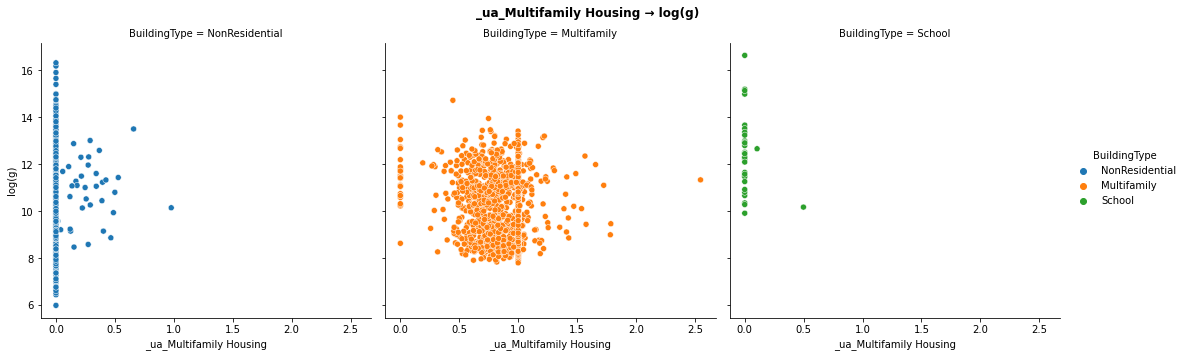

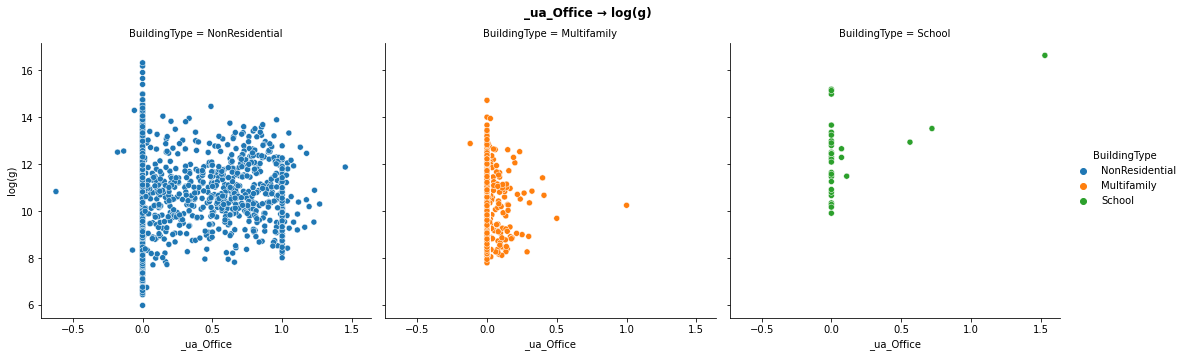

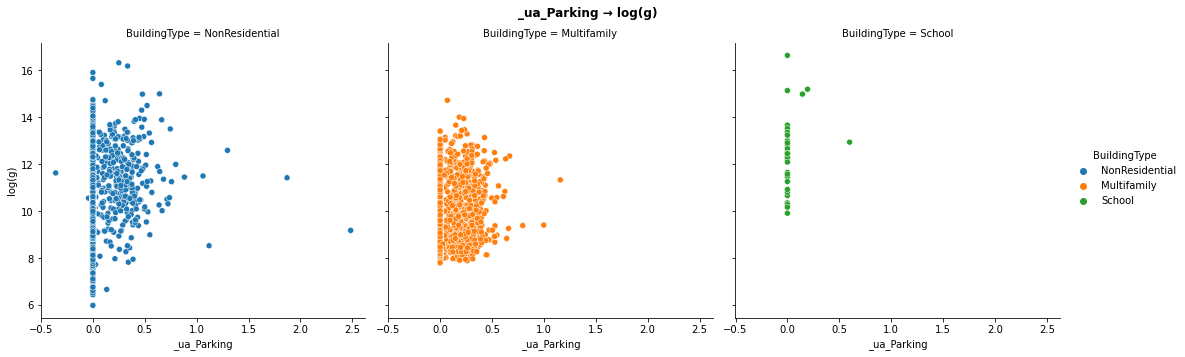

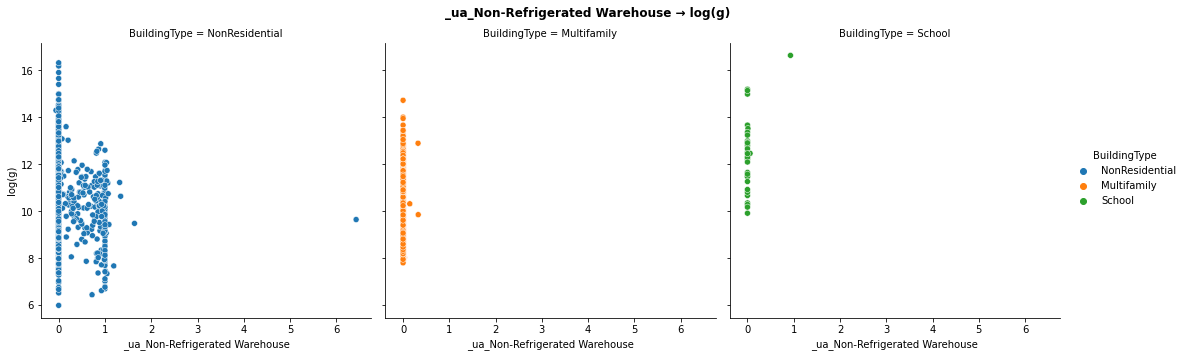

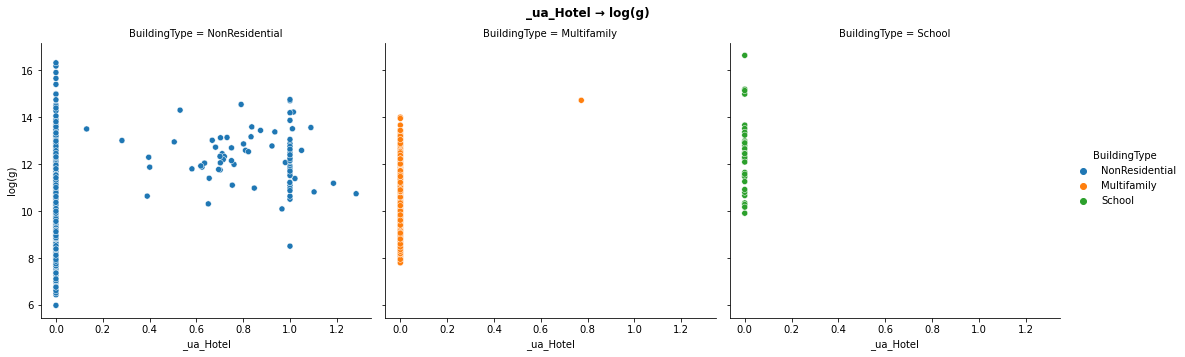

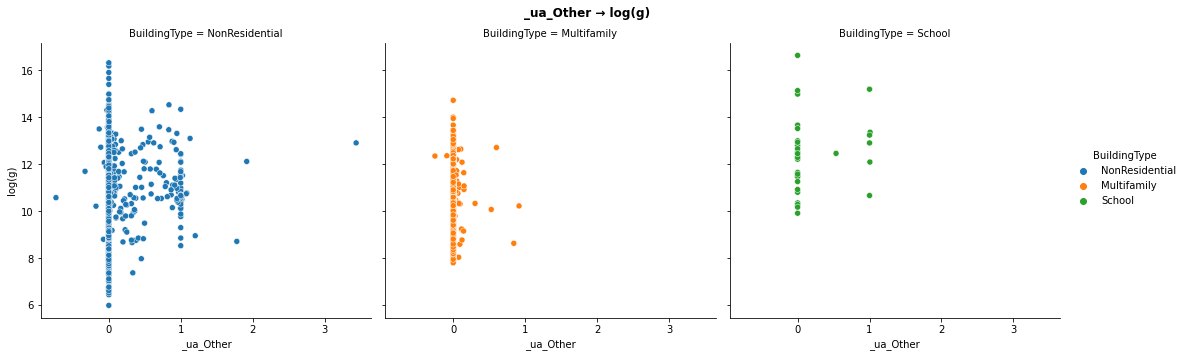

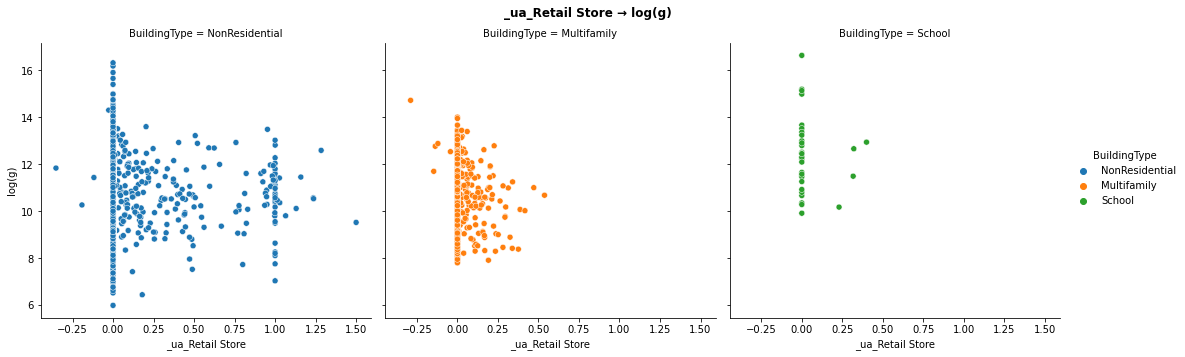

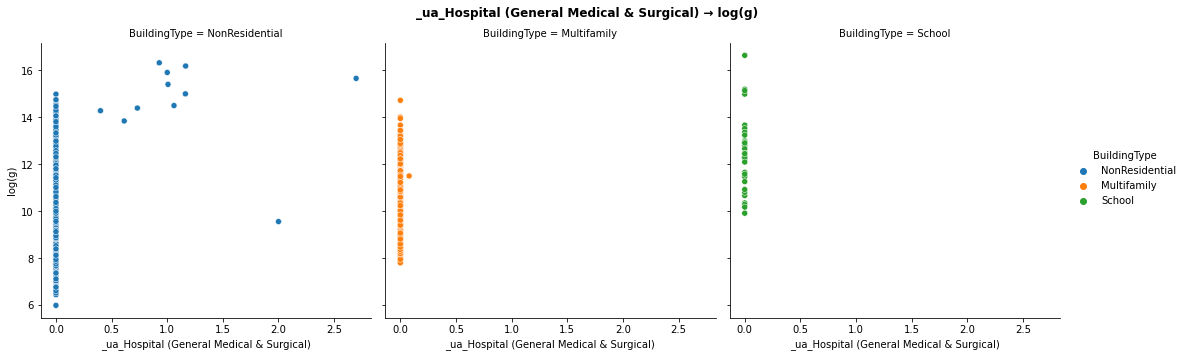

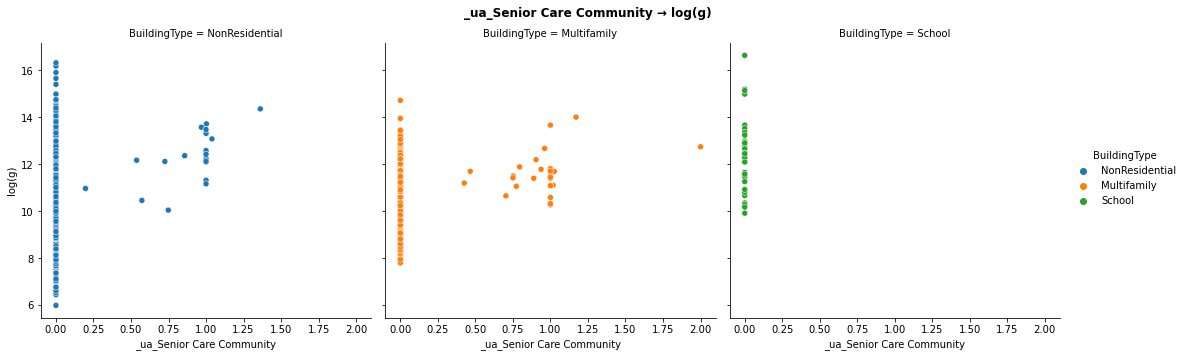

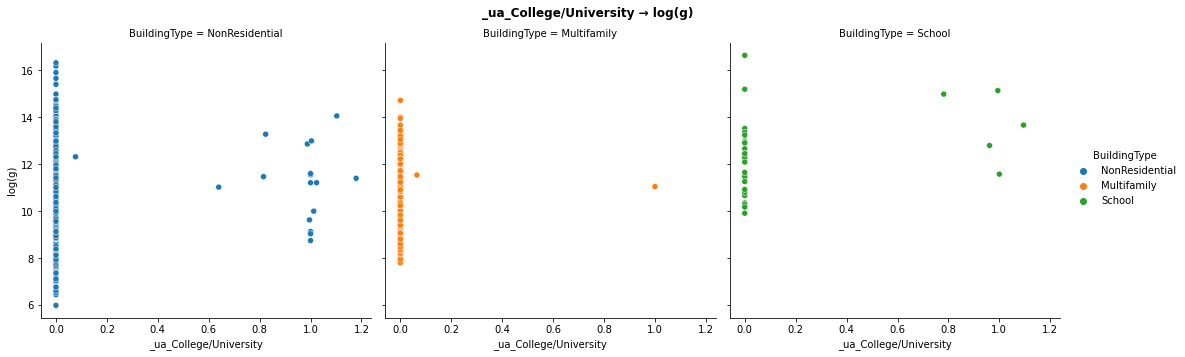

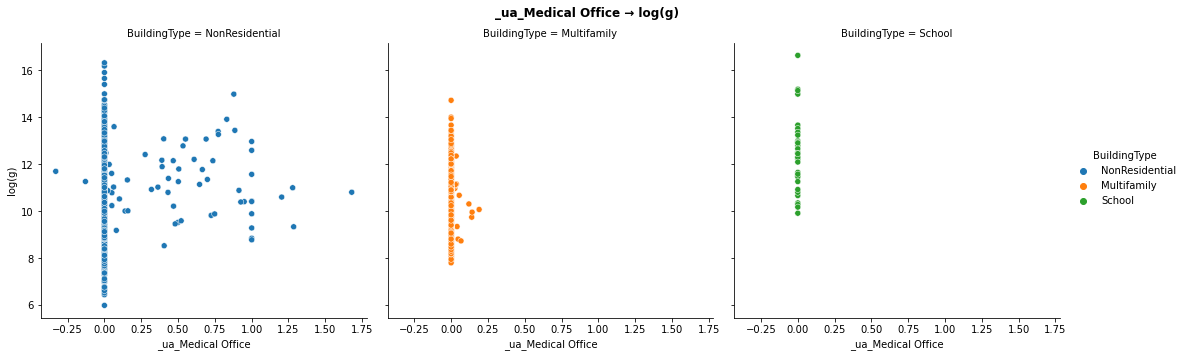

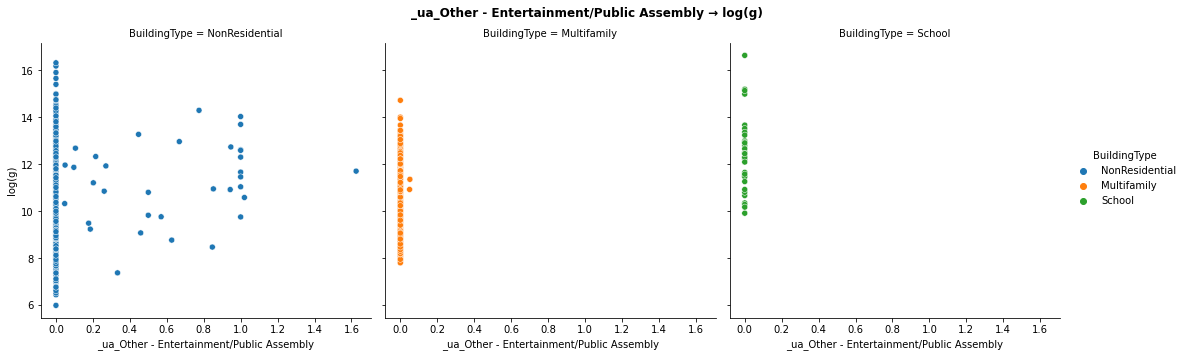

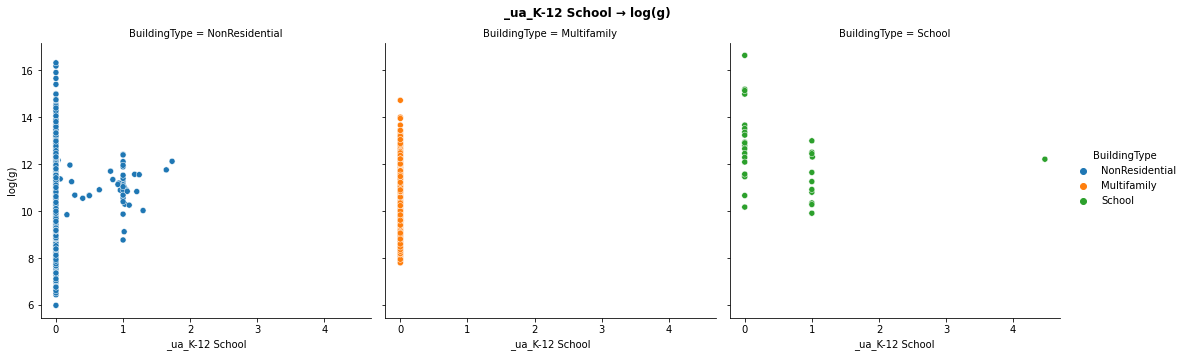

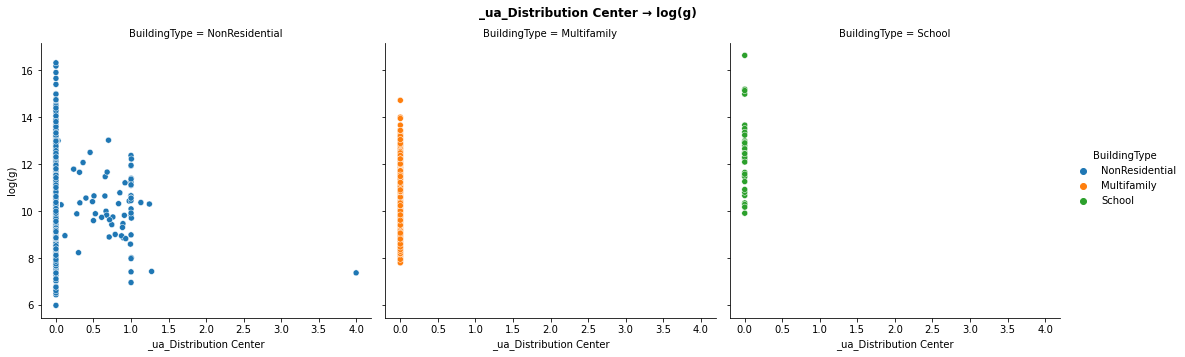

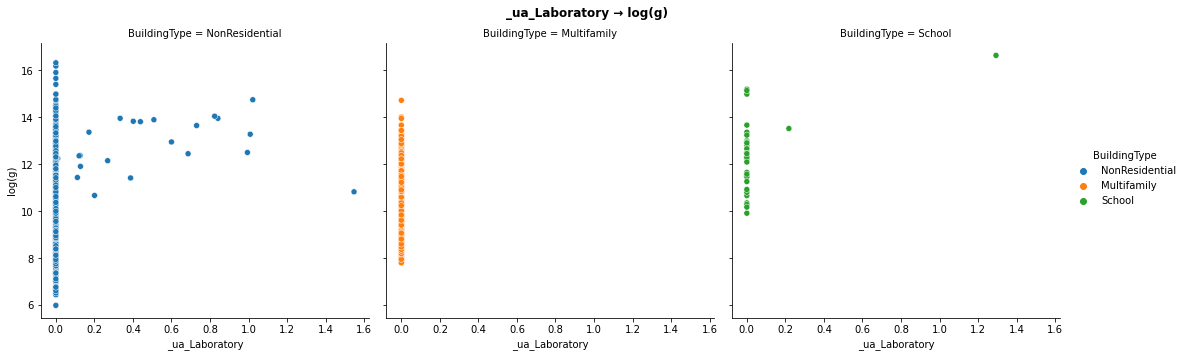

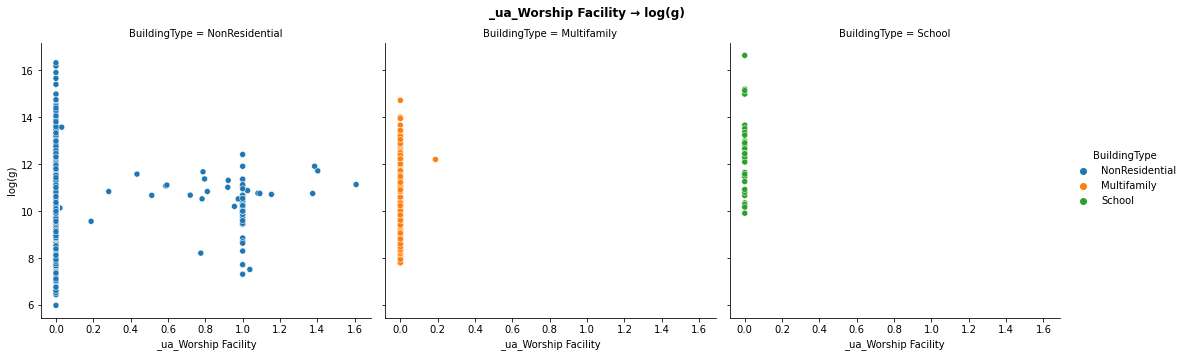

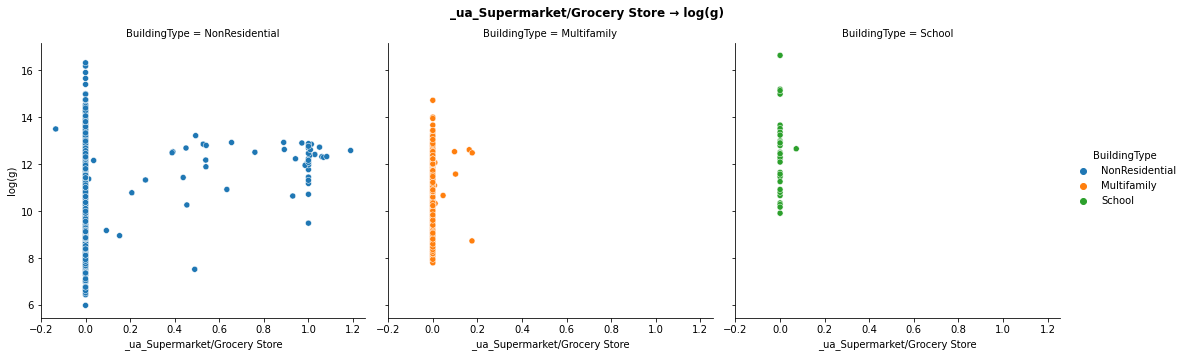

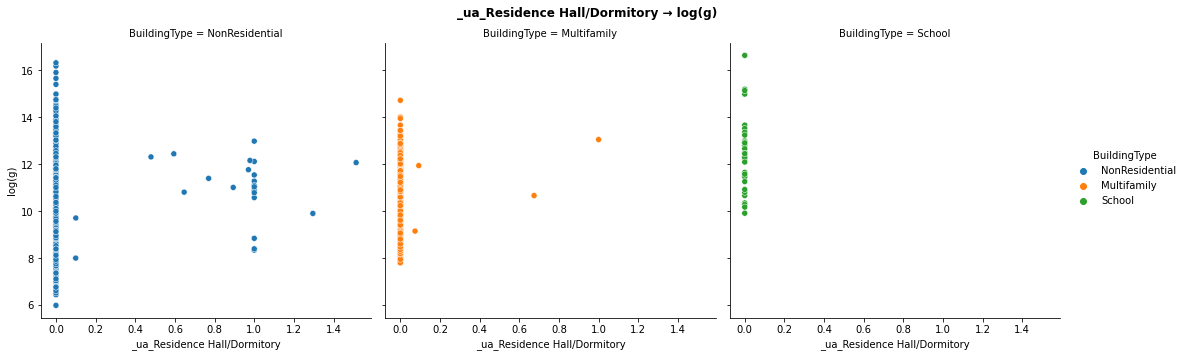

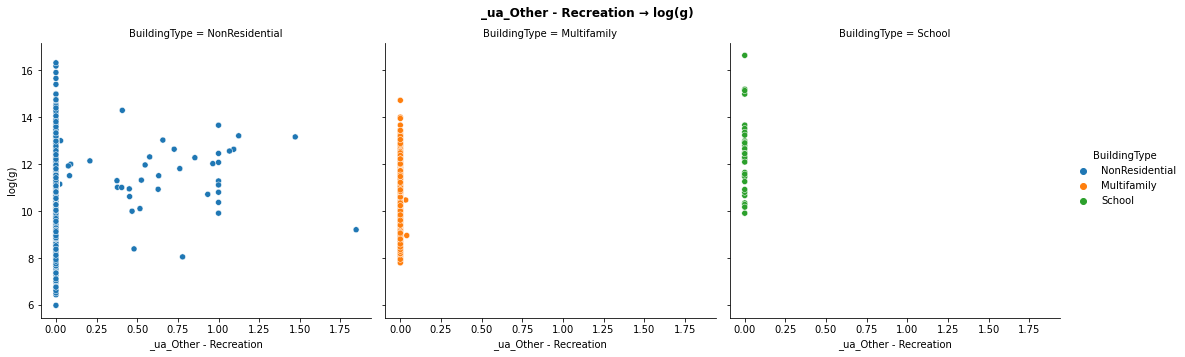

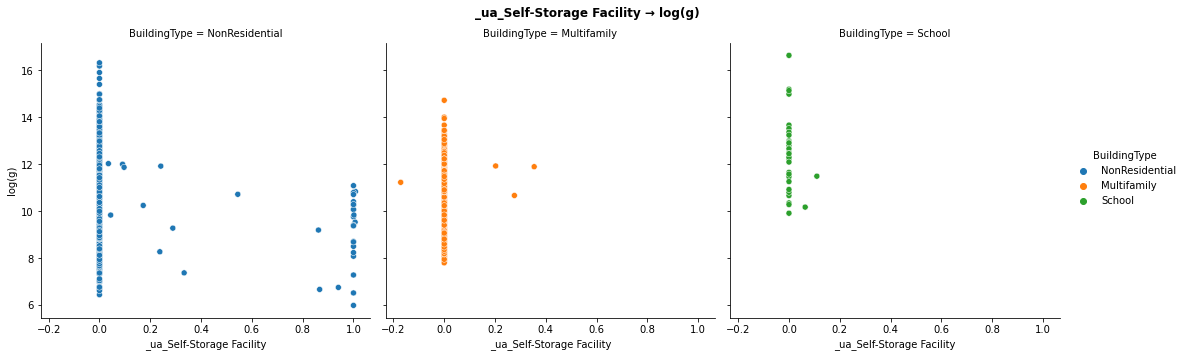

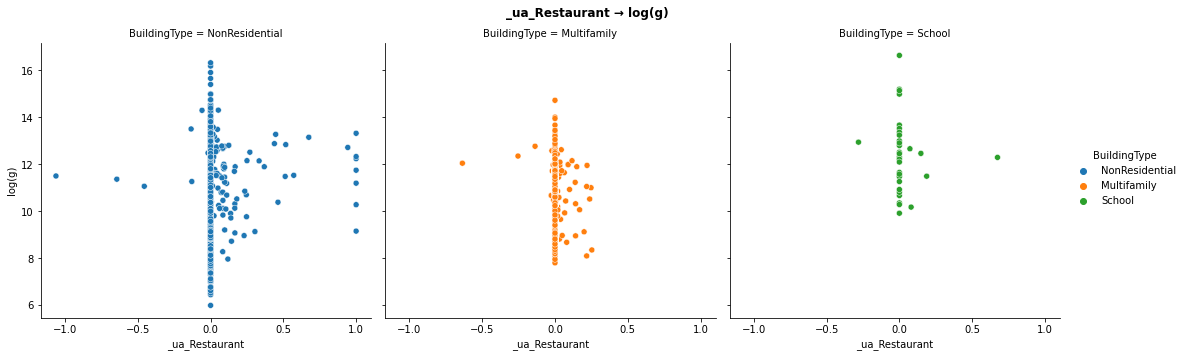

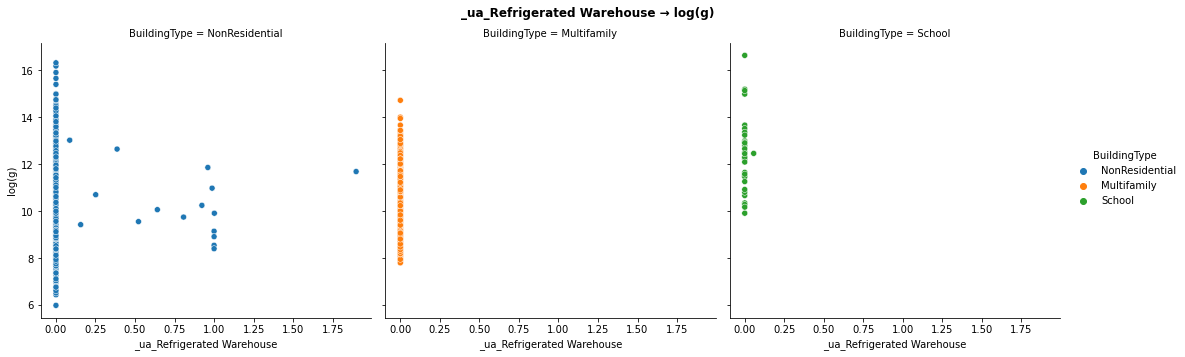

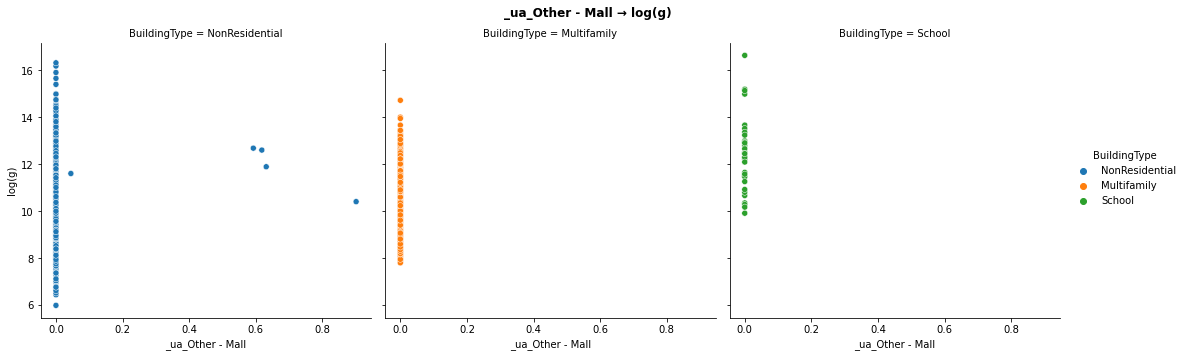

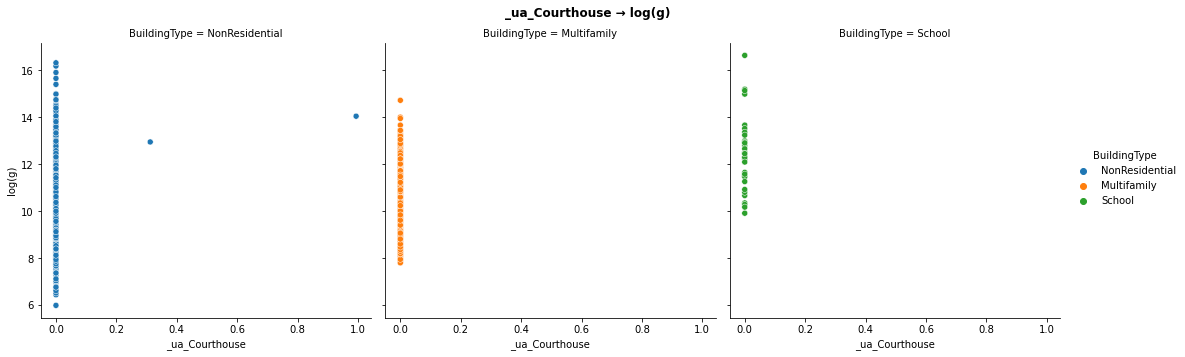

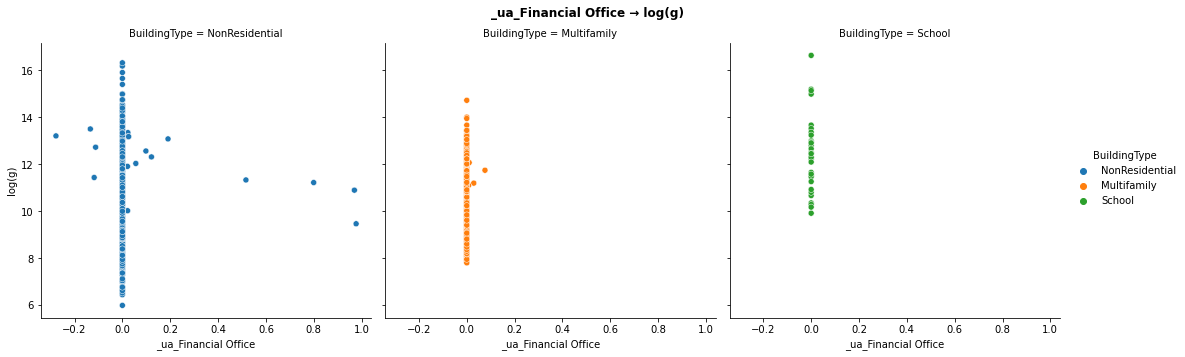

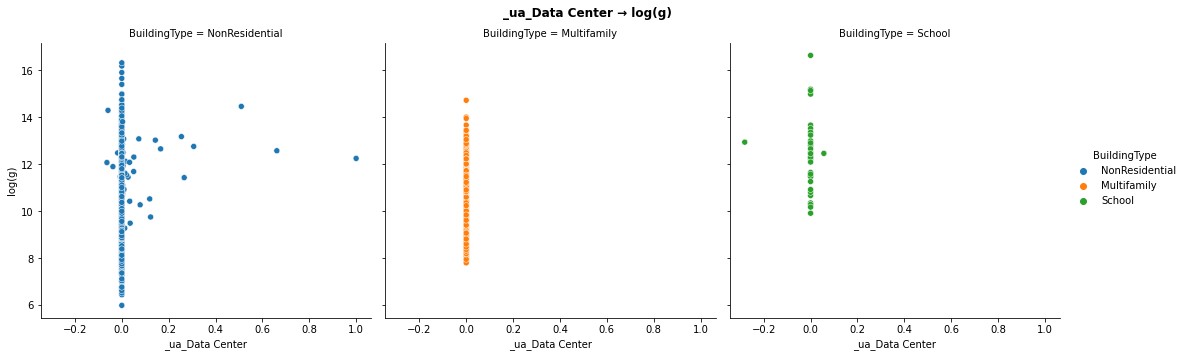

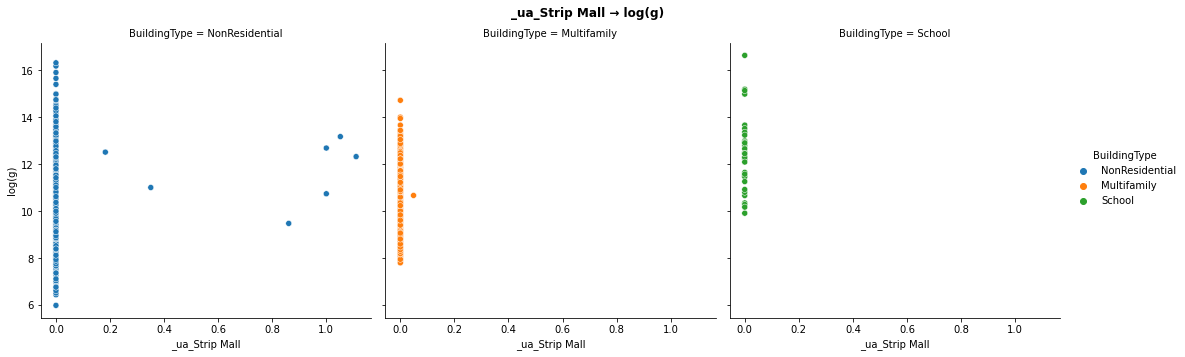

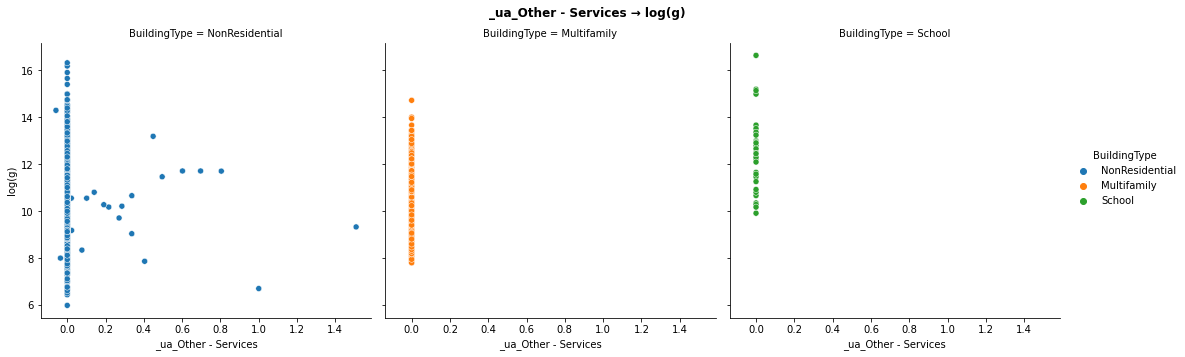

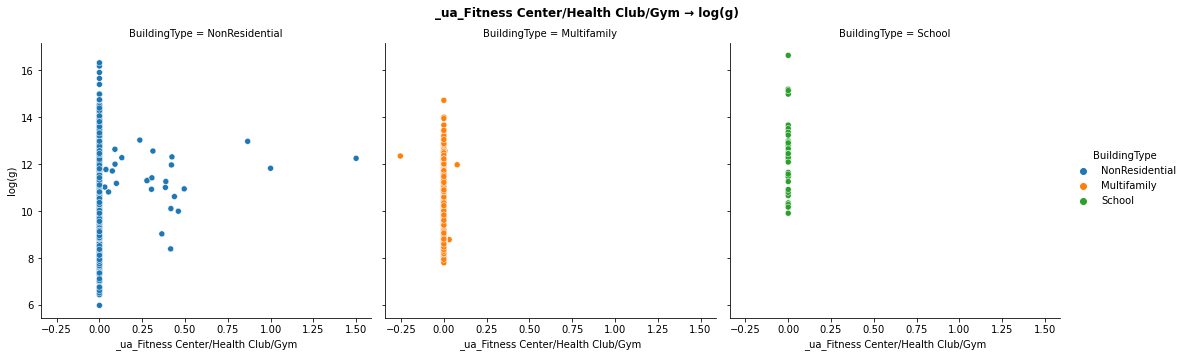

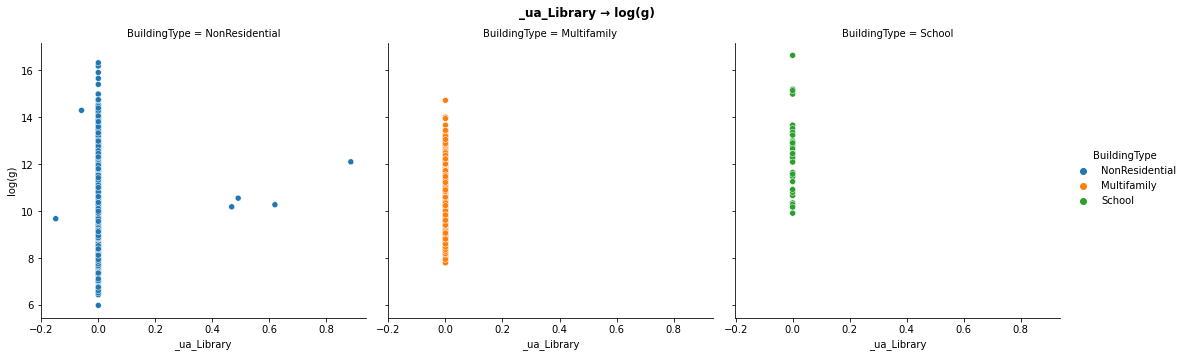

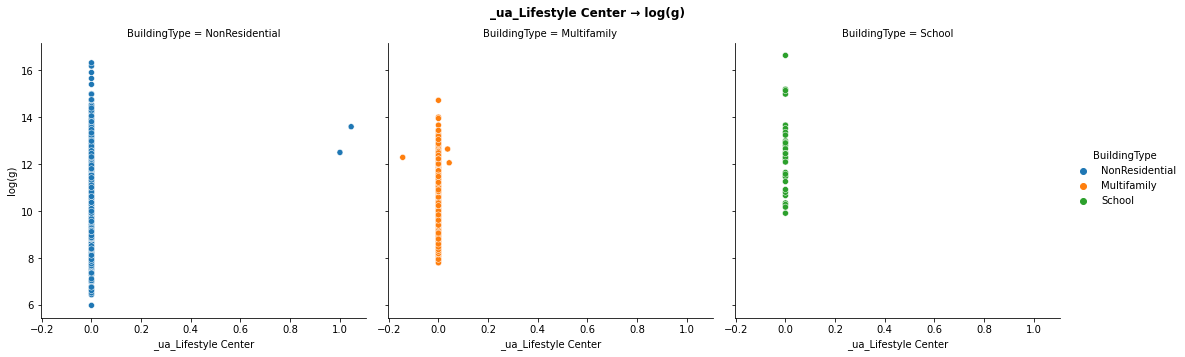

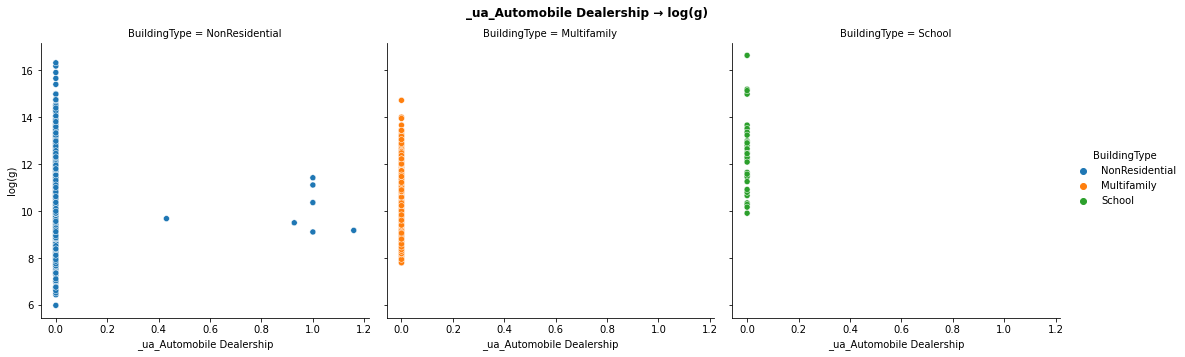

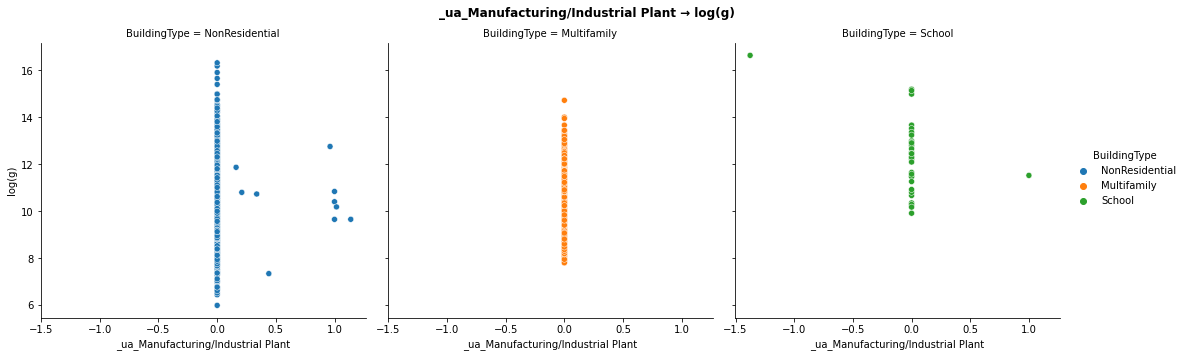

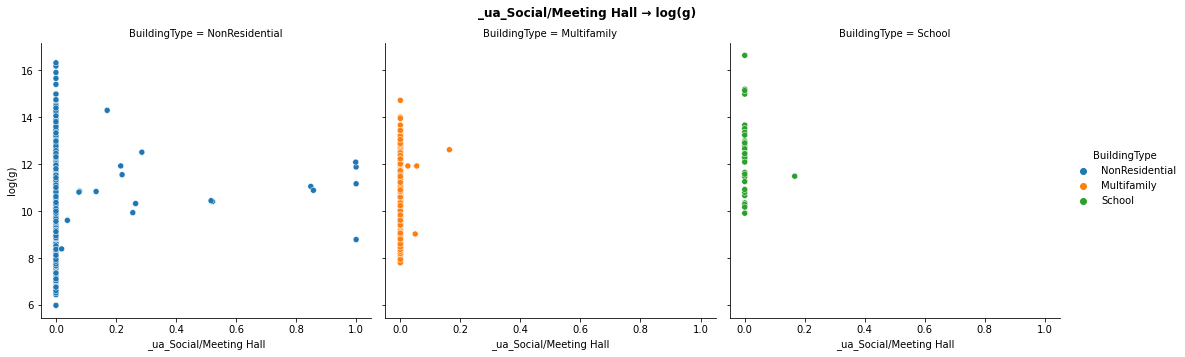

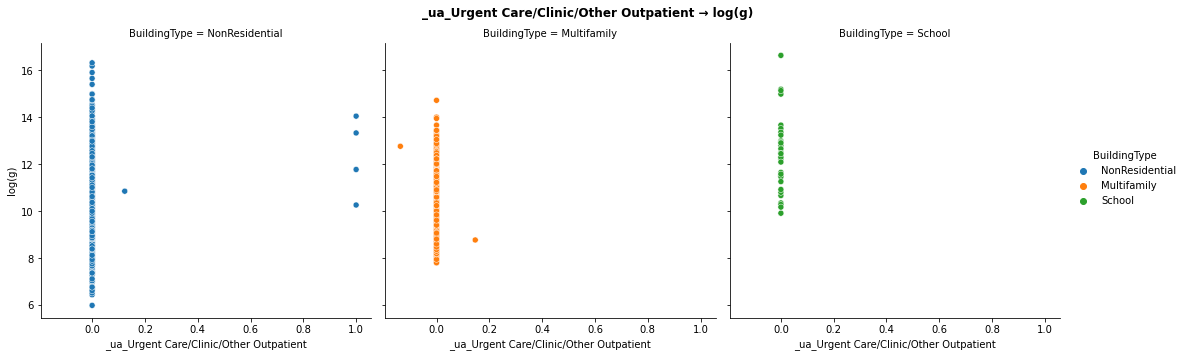

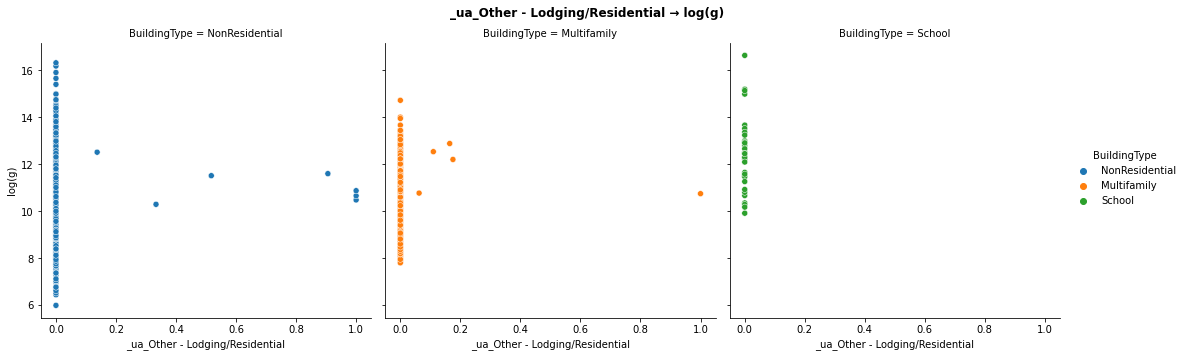

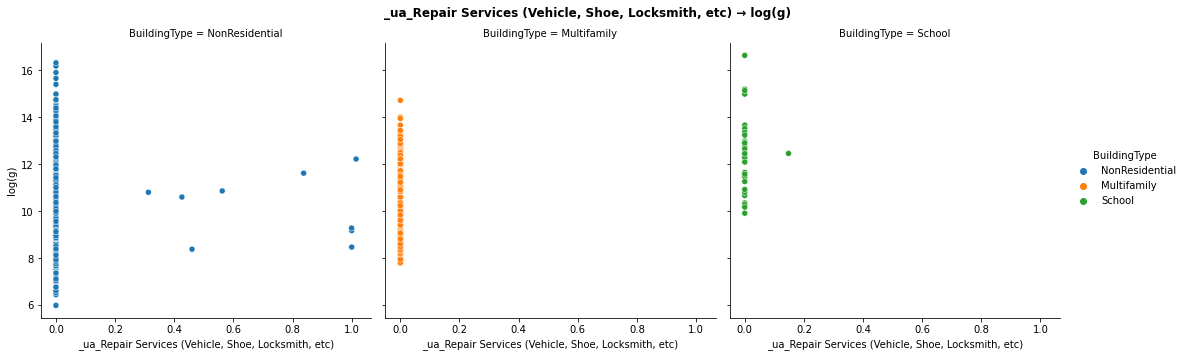

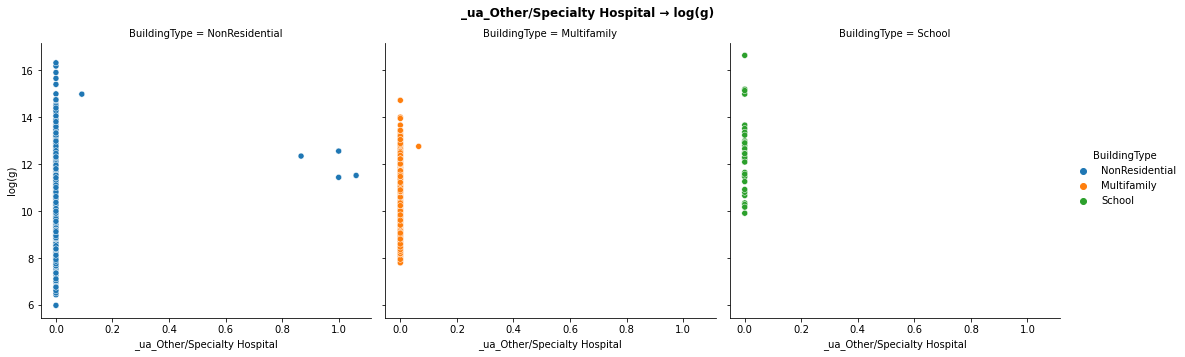

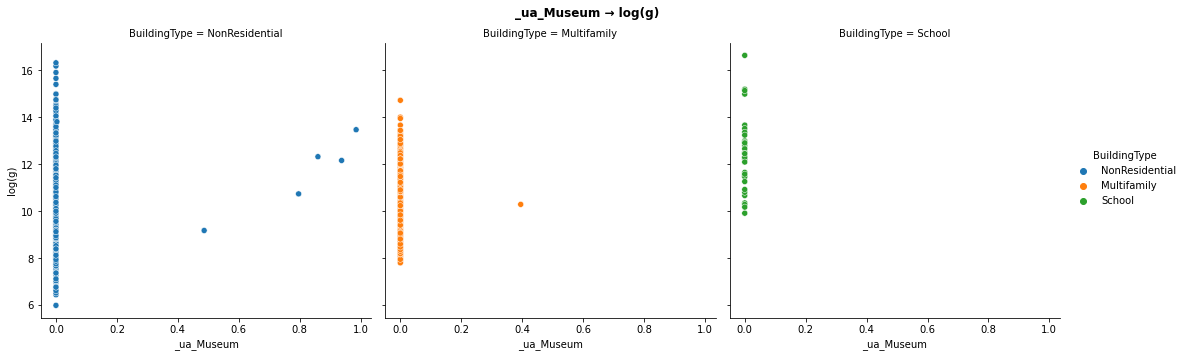

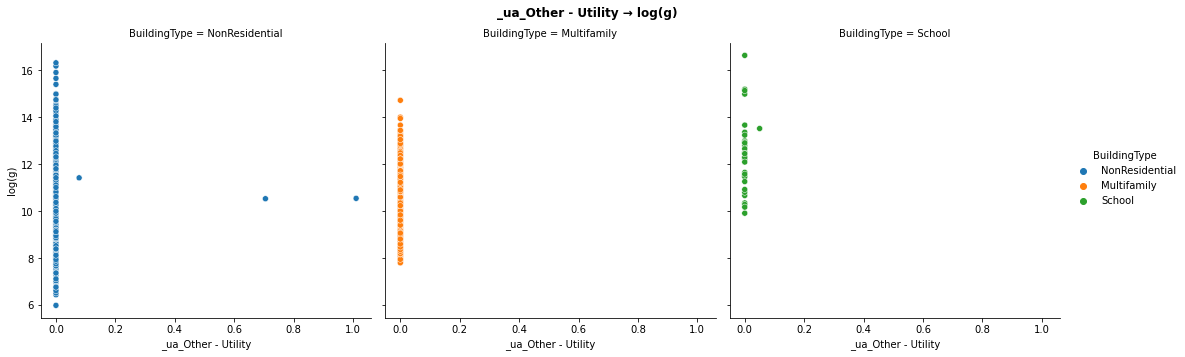

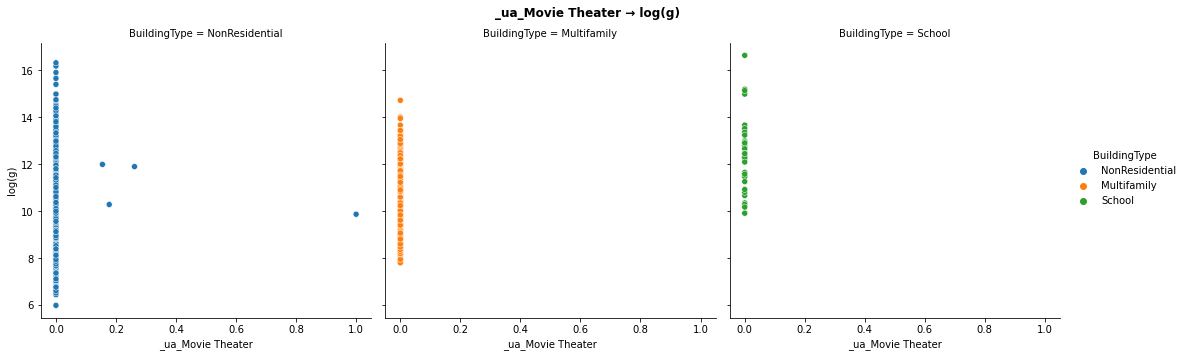

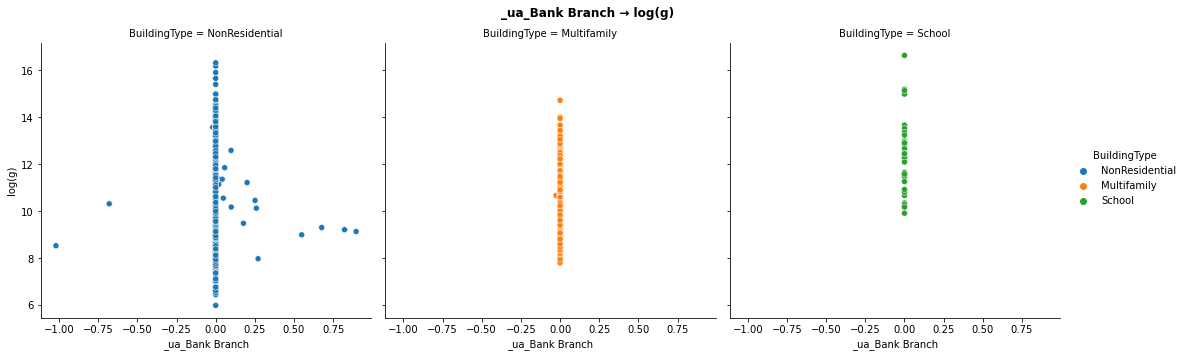

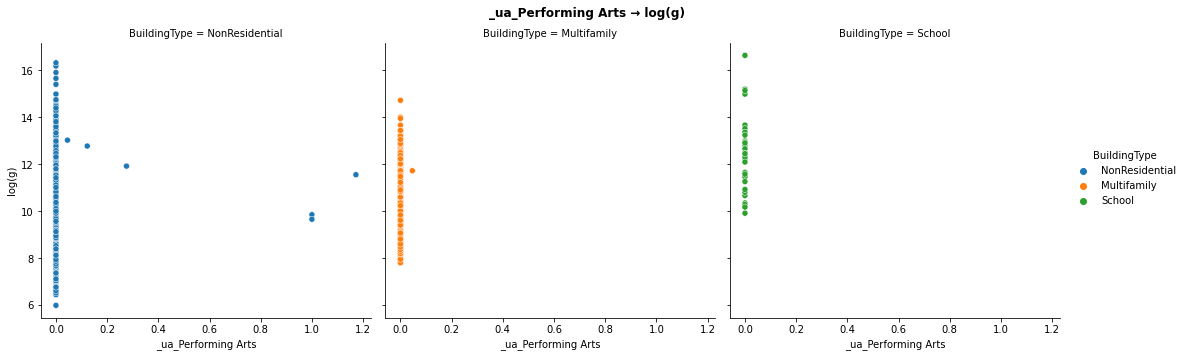

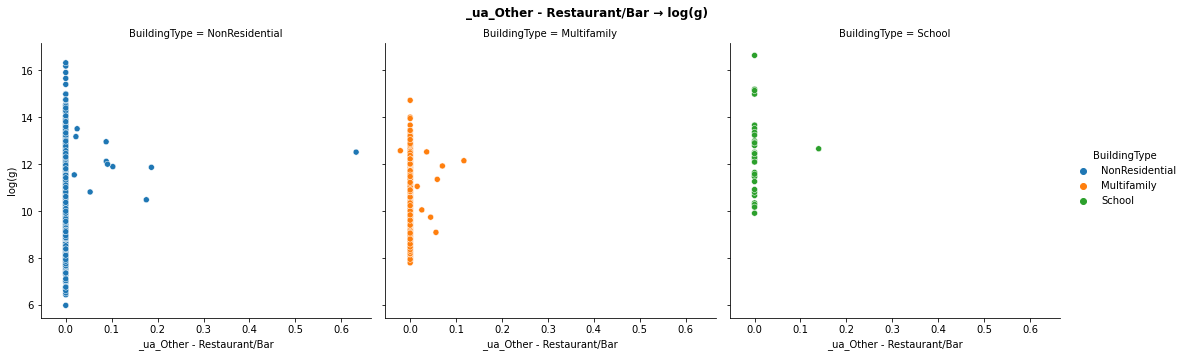

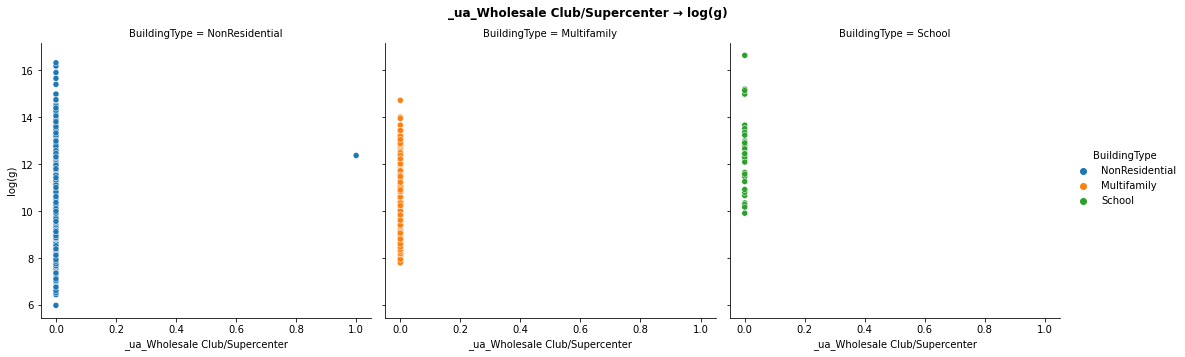

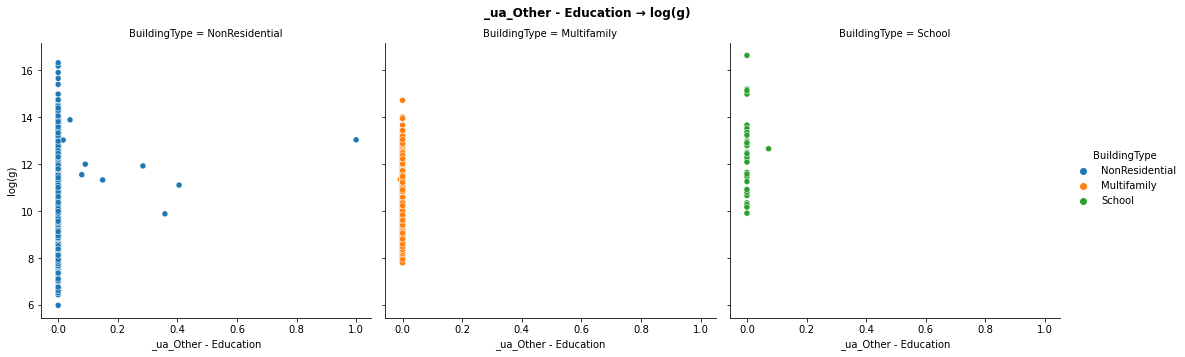

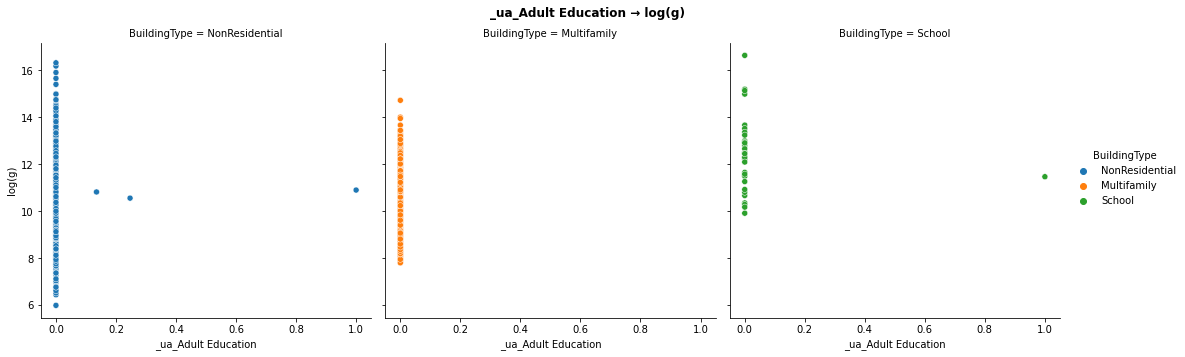

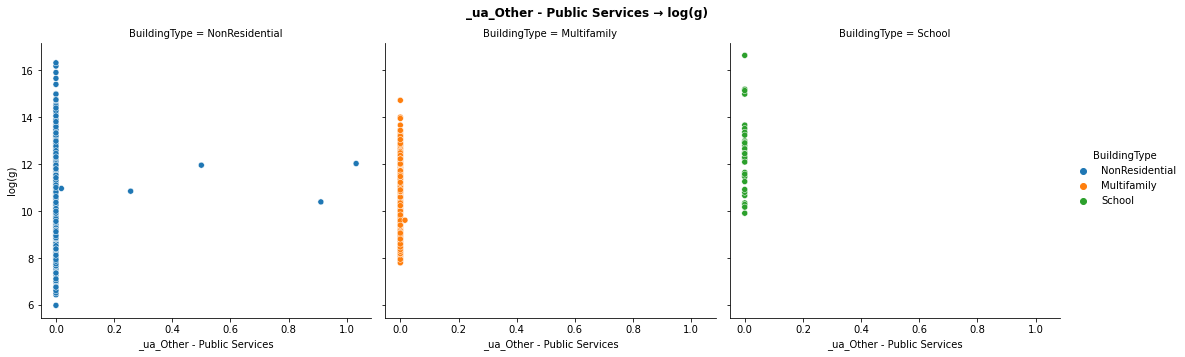

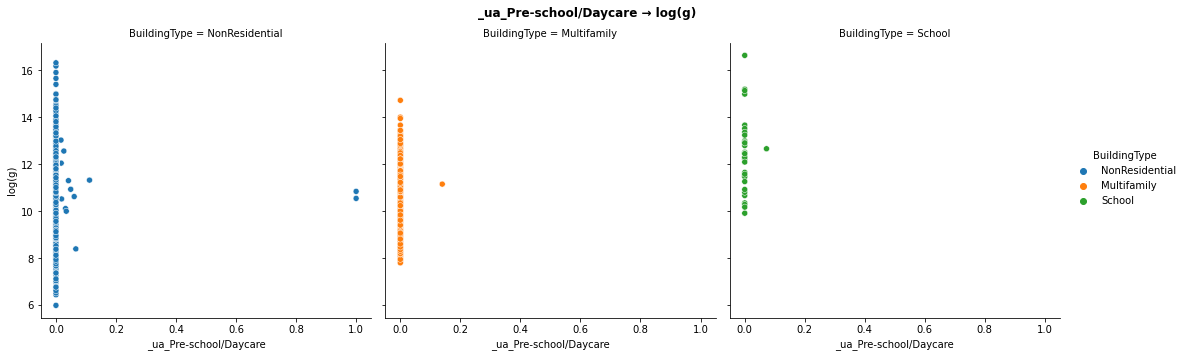

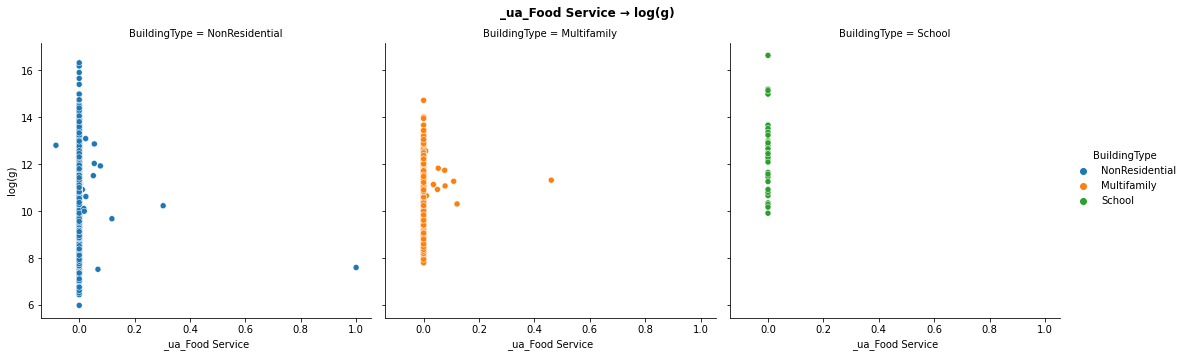

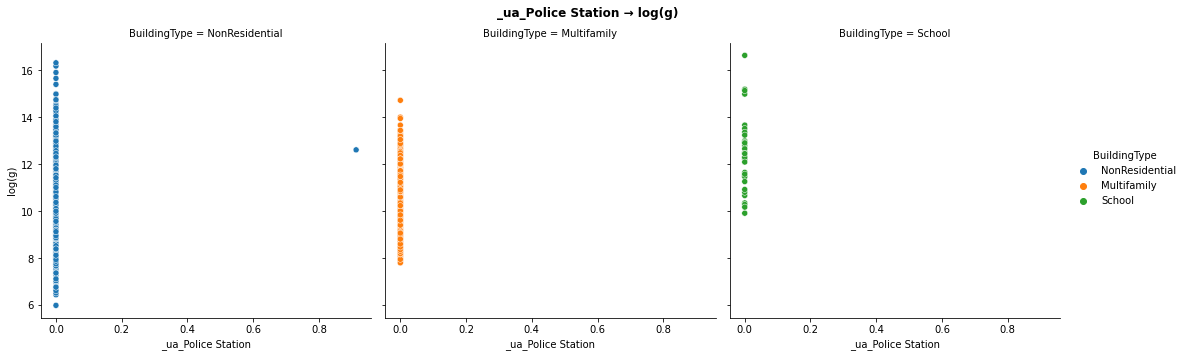

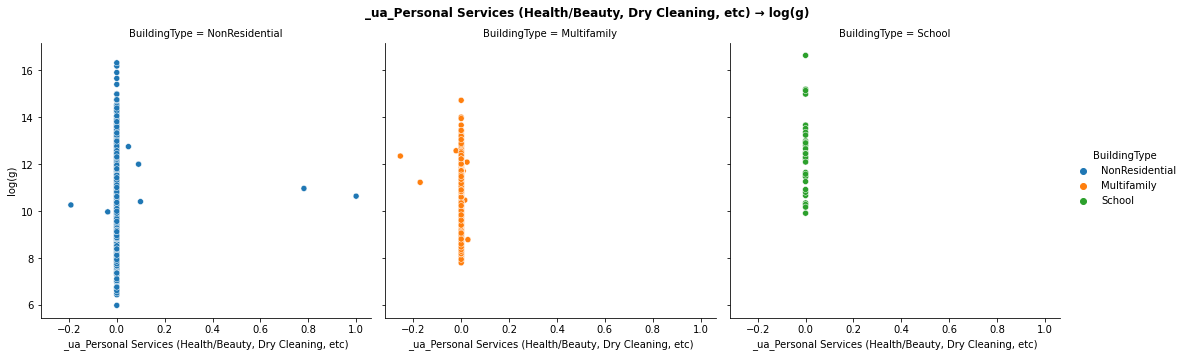

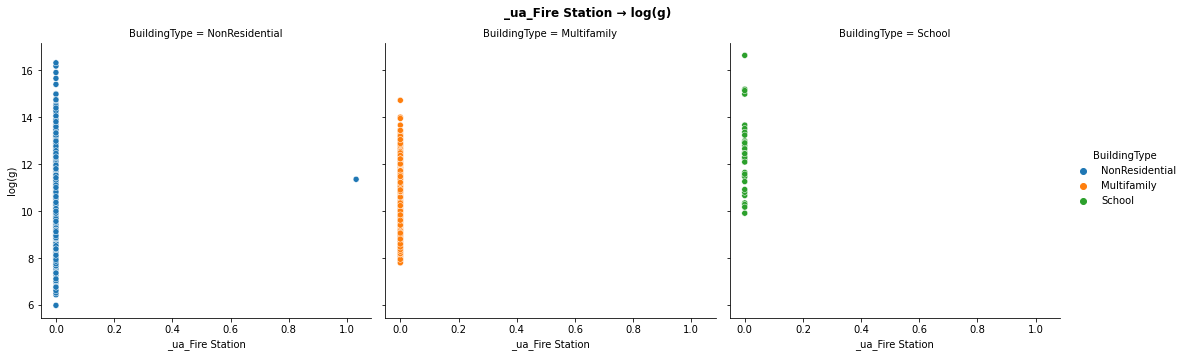

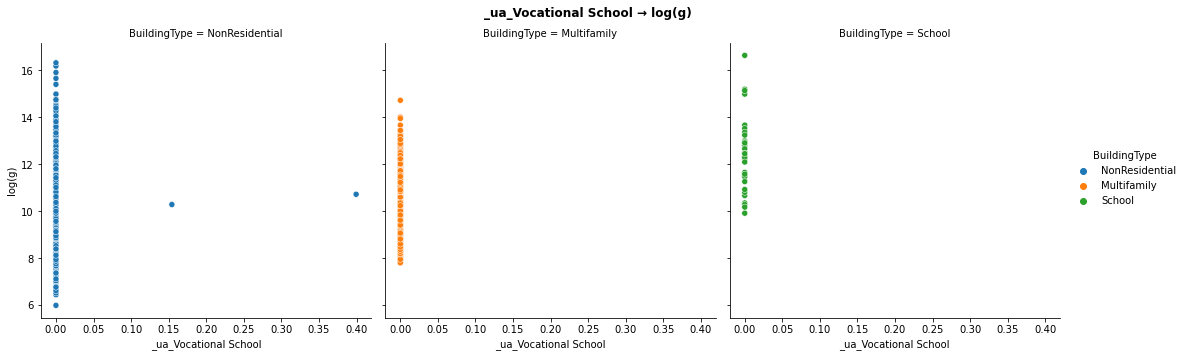

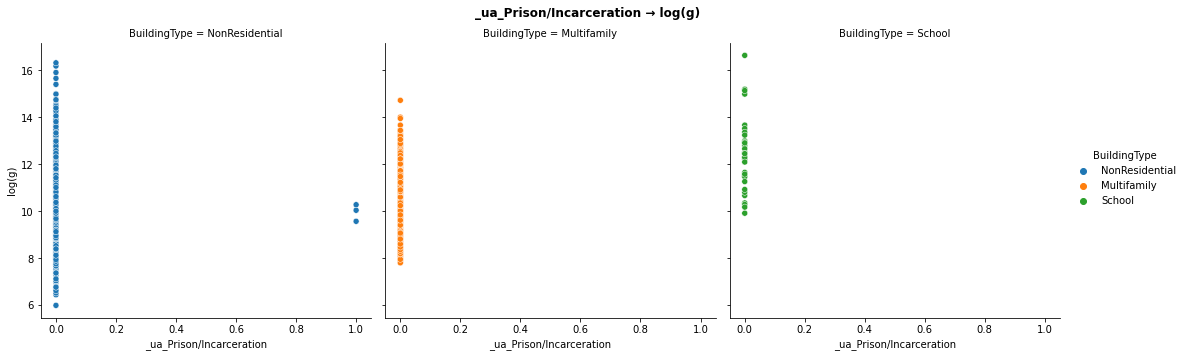

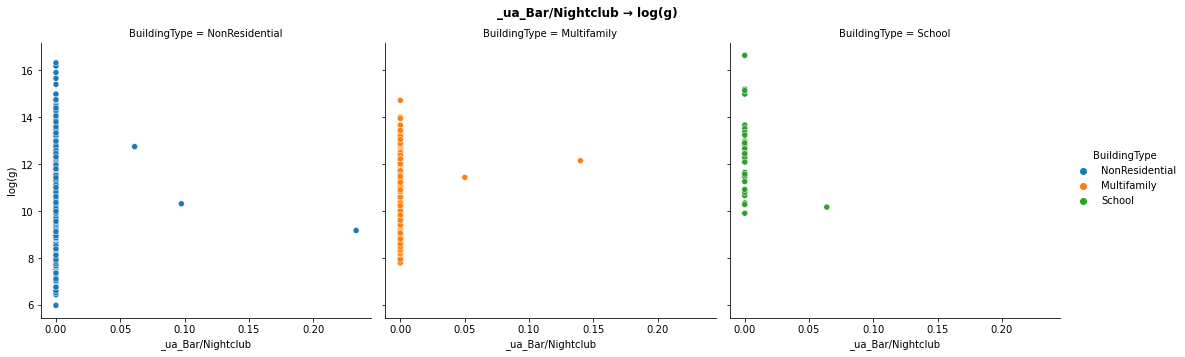

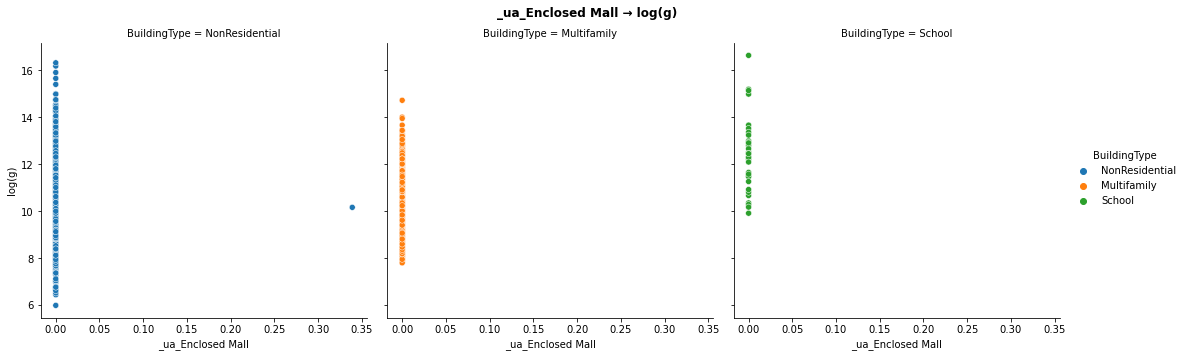

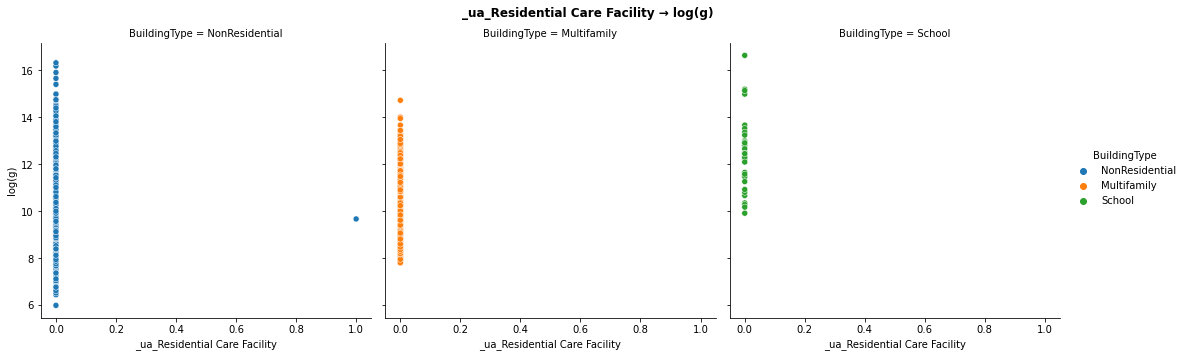

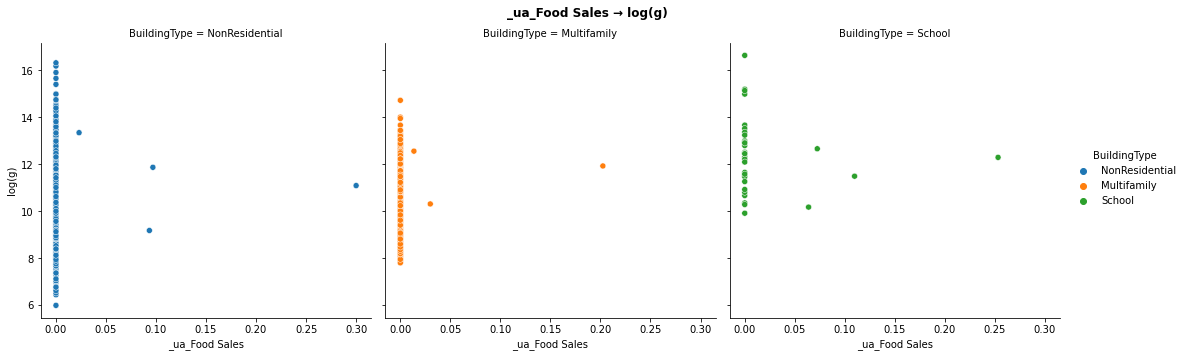

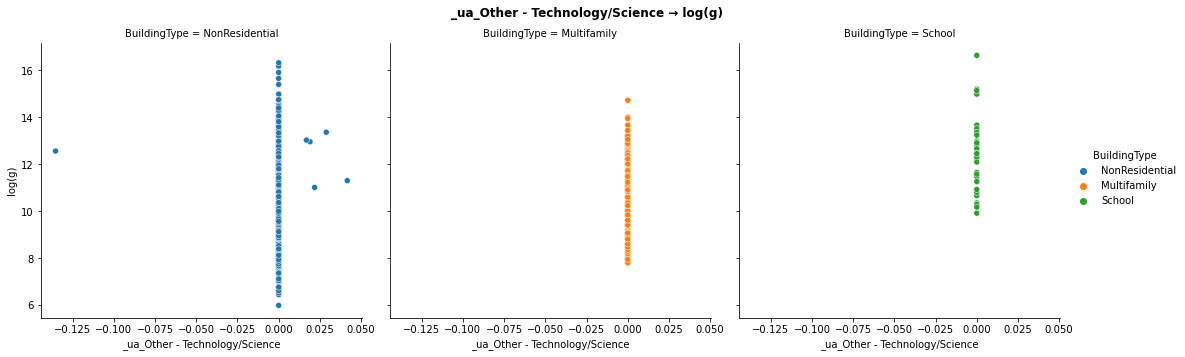

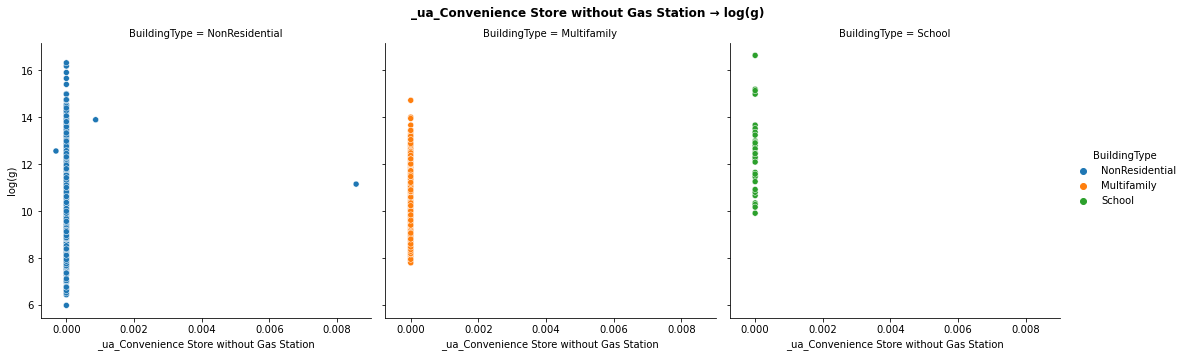

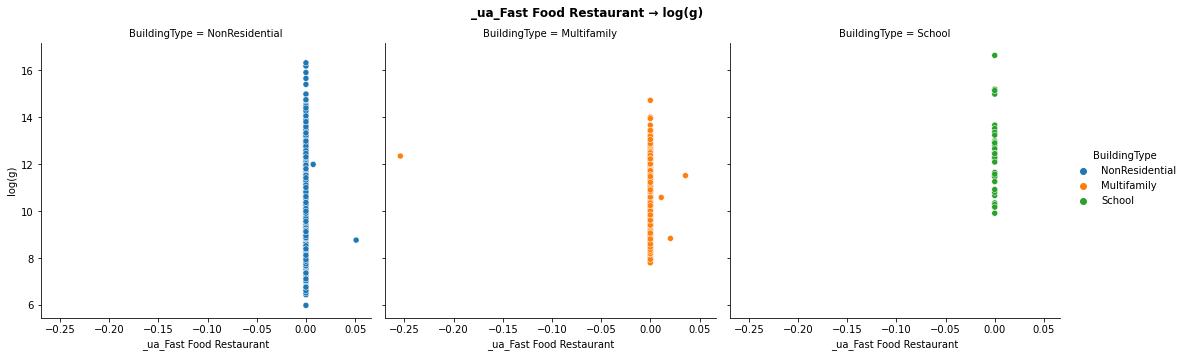

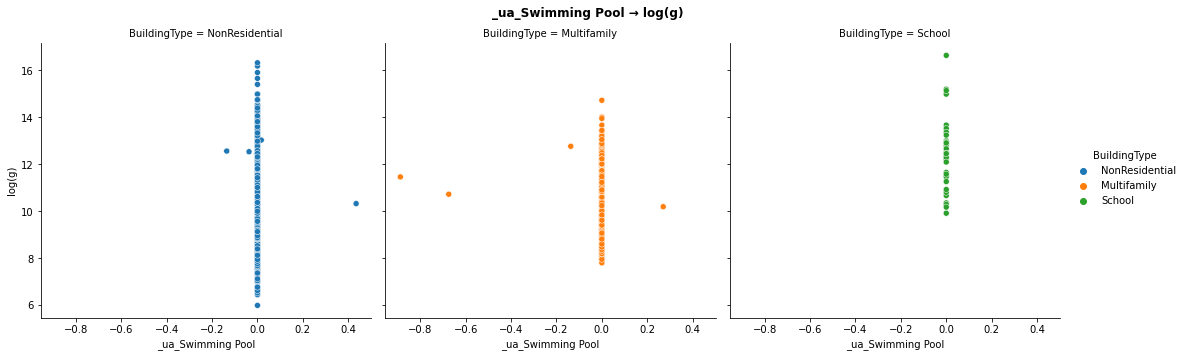

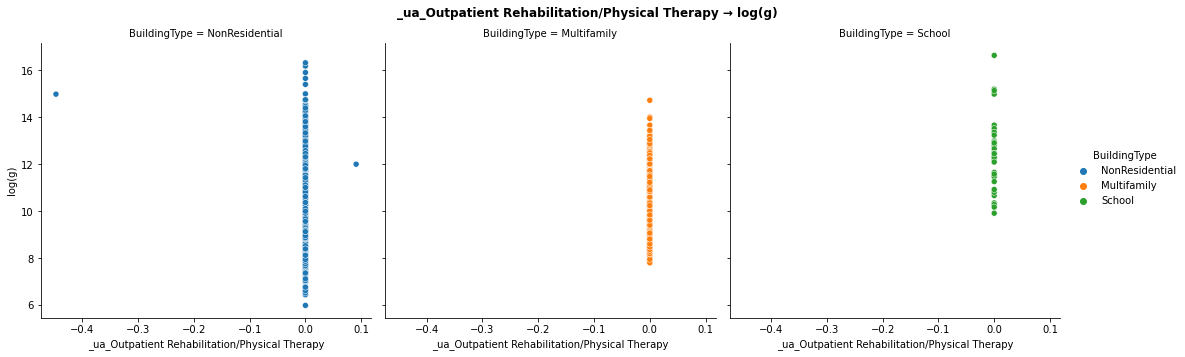

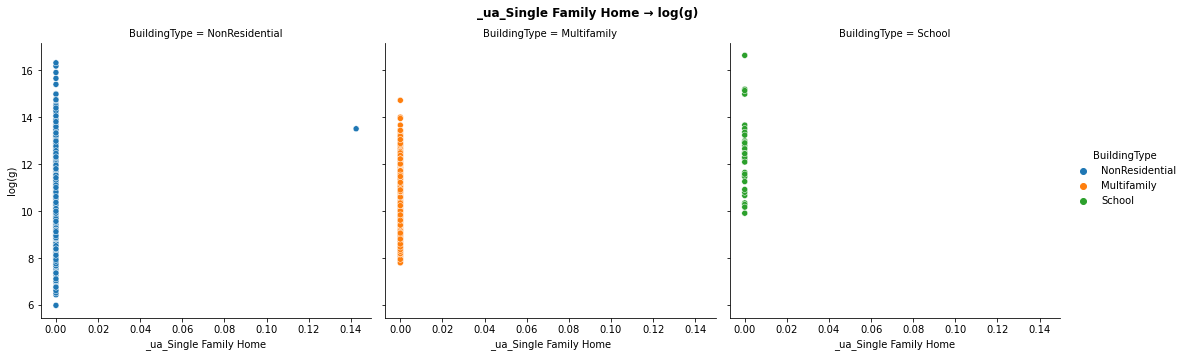

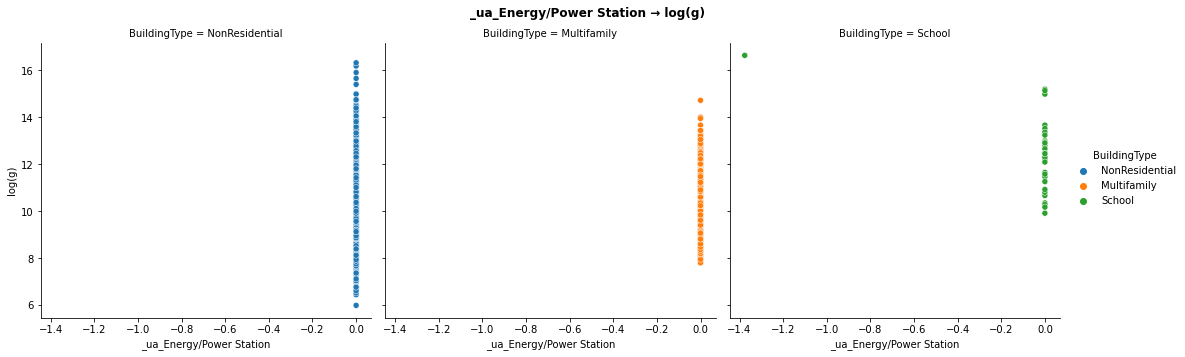

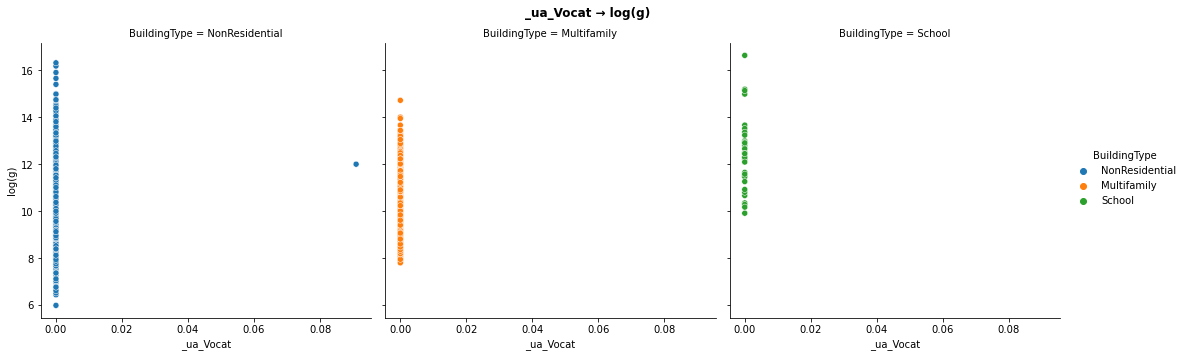

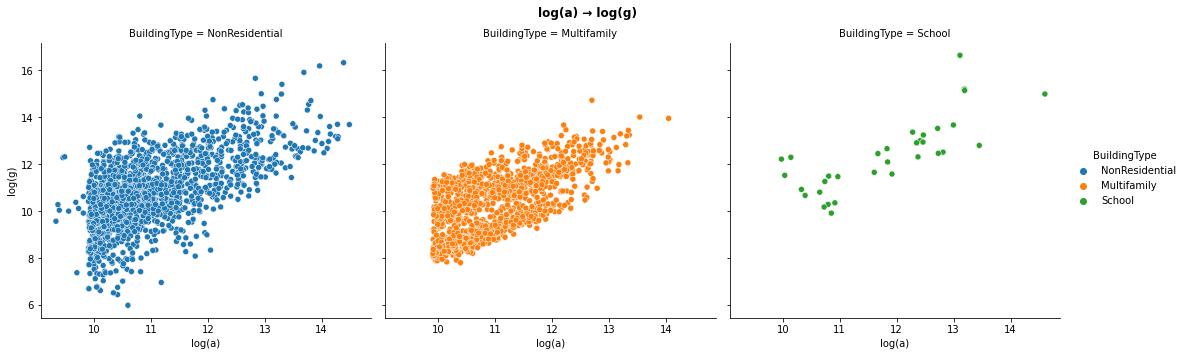

In [54]:
from seattle_commons import get_abstract_btype, plot_ml_data_all
btype = get_abstract_btype(data)
plot_ml_data_all(ml_data, btype)

#### Vérifications

In [55]:
from seattle_commons import check_data
check_data(ml_data)

✘ Negative coefficients :


,_ua_Multifamily Housing,_ua_Office,_ua_Parking,_ua_Non-Refrigerated Warehouse,_ua_Hotel,_ua_Other,_ua_Retail Store,_ua_Hospital (General Medical & Surgical),_ua_Senior Care Community,_ua_College/University,...,_ua_Other - Technology/Science,_ua_Convenience Store without Gas Station,_ua_Fast Food Restaurant,_ua_Swimming Pool,_ua_Outpatient Rehabilitation/Physical Therapy,_ua_Single Family Home,_ua_Energy/Power Station,_ua_Vocat,log(a),log(g)
id,,,,,,,,,,,,,,,,,,,,,
32,0.000000,0.000000,0.264690,0.000000,0.710101,0.000000,0.028360,0.0,0.0000,0.0,...,0.000000,0.000000,0.000000,-0.003151,0.000000,0.0,0.000000,0.0,11.974620,12.455157
43,0.000000,1.529857,0.000000,0.929094,0.000000,0.000000,0.000000,0.0,0.0000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-1.376086,0.0,13.111980,16.641106
100,0.000000,0.827762,0.476520,0.000000,0.000000,0.047862,-0.352143,0.0,0.0000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,12.664465,11.841149
234,0.000000,0.094051,0.000000,0.841983,0.000000,0.000000,0.000000,0.0,0.0000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,10.825601,8.006368
238,0.000000,0.636102,0.130034,0.000000,0.000000,-0.063475,0.000000,0.0,0.0000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,11.420042,12.076932
247,0.000000,0.208310,0.000000,0.000000,0.000000,0.142570,0.000000,0.0,0.0000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,12.096040,11.476573
248,0.000000,0.196675,0.000000,0.696299,0.000000,-0.178359,0.000000,0.0,0.0000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,10.979172,10.217933
264,0.528618,0.000000,0.269342,0.000000,0.000000,0.000000,-0.117963,0.0,0.0000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,11.615347,11.439387
265,0.698949,0.234320,0.000000,0.000000,0.000000,0.000000,-0.043156,0.0,0.0000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,11.669476,12.540221


✔ No NA coefficient


#### Partition

In [56]:
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Entraînement

##### Recherche en grille externe

In [57]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    lr = linear_model.LinearRegression()
    lr_reg = lr.fit(X_train, y_train)
    baseline_err = cross_val_score(lr_reg, X_train, y_train, cv=5).mean()
    print(baseline_err)

-0.2750250373657225


In [58]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_commons import print_title, print_subtitle, bold
import time
from pepper_skl_commons import Dataset, get_baseline_err, search_best_params, get_best_params

Xy = X_train, X_test, y_train, y_test
model = linear_model.Ridge()
min_alpha_log = -1
max_alpha_log = 1
n_alphas = 100

param_grid = {
    'alpha': np.logspace(min_alpha_log, max_alpha_log, n_alphas),
    'solver': ['auto', 'svd', 'sparse_cg', 'sag', 'saga', 'cholesky', 'lsqr'], #, 'lbfgs'
    'random_state': [42]
}

best_estimator = best_params = best_score = best_index = scorer = cv_res = None
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    (
        best_estimator,
        best_params,
        best_score,
        best_index,
        scorer,
        cv_res
    ) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

coucoukookoo


In [59]:
import warnings
with warnings.catch_warnings():
    print('best', bold('estimator'), ':', best_estimator)
    print('best', bold('params'), ':', best_params)
    print('best', bold('score'), ':', best_score)
    print('best', bold('index'), ':', best_index)
    print(bold('scorer'), ':', scorer)

    print(' train', bold('score'), ':', best_estimator.score(X_train, y_train))
    print('  test', bold('score'), ':', best_estimator.score(X_test, y_test))
    print('global', bold('score'), ':', best_estimator.score(X, y))

    print('best', bold('estimator'), 'intercept :', best_estimator.intercept_)
    print('best', bold('estimator'), '    coefs :', best_estimator.coef_)

    from seattle_commons import show_ols_scores # TODO : à renommer
    show_ols_scores(best_estimator, X, y, cv=3)

best estimator : Ridge(alpha=1.7073526474706913, random_state=42, solver='sparse_cg')
best params : {'alpha': 1.7073526474706913, 'random_state': 42, 'solver': 'sparse_cg'}
best score : 0.47612917285846856
best index : 429
scorer : <function _passthrough_scorer at 0x000001EE031CA790>
 train score : 0.5299817979826456
  test score : 0.5291216638477334
global score : 0.5293719047207406
best estimator intercept : -0.5382500561937071
best estimator     coefs : [-5.56114283e-01 -2.11753127e-01 -5.16750904e-01 -4.88044248e-01
  6.44700284e-01  4.40469872e-01 -5.29467246e-03  8.46801400e-01
  3.30297755e-01  2.52910220e-01  2.58320046e-01  5.84423075e-01
  3.88932027e-01 -5.17249479e-01  9.43224701e-01  2.97111021e-01
  1.50191137e+00  5.37268966e-02  1.33183691e+00 -9.72917477e-01
  1.47147254e+00 -2.94486547e-02  3.51195201e-01  7.31090062e-02
 -3.69358374e-02  1.12227622e-02 -4.28362611e-02 -5.54576168e-02
  7.97771388e-01  3.77208325e-02  4.33977666e-01  2.99594957e-01
  2.83976734e-01  7

In [60]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
429,0.004999,0.000894,0.003000,6.322610e-04,1.707353,42,sparse_cg,"{'alpha': 1.7073526474706913, 'random_state': ...",0.433615,0.457491,0.521339,0.467065,0.501135,0.476129,0.031325,1
443,0.004800,0.000401,0.002802,3.994036e-04,1.873817,42,sparse_cg,"{'alpha': 1.873817422860385, 'random_state': 4...",0.433476,0.458626,0.520664,0.466385,0.501445,0.476119,0.031128,2
434,0.005002,0.000632,0.003399,1.019244e-03,1.78865,42,auto,"{'alpha': 1.7886495290574351, 'random_state': ...",0.433657,0.458010,0.521148,0.466362,0.501412,0.476118,0.031284,3
439,0.004401,0.000505,0.003392,7.933538e-04,1.78865,42,cholesky,"{'alpha': 1.7886495290574351, 'random_state': ...",0.433657,0.458010,0.521148,0.466362,0.501412,0.476118,0.031284,3
435,0.007601,0.000800,0.003399,4.896323e-04,1.78865,42,svd,"{'alpha': 1.7886495290574351, 'random_state': ...",0.433657,0.458010,0.521148,0.466362,0.501412,0.476118,0.031284,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,0.008401,0.000801,0.003800,3.991628e-04,0.104762,42,sparse_cg,"{'alpha': 0.10476157527896648, 'random_state':...",0.414412,0.428744,0.523218,0.453050,0.380625,0.440010,0.047754,696
5,0.005001,0.000634,0.003401,7.990948e-04,0.1,42,cholesky,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.416805,0.427554,0.521768,0.449443,0.381215,0.439357,0.046737,697
0,0.005399,0.001017,0.002999,2.786133e-06,0.1,42,auto,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.416805,0.427554,0.521768,0.449443,0.381215,0.439357,0.046737,697
1,0.006600,0.000800,0.003398,4.906242e-04,0.1,42,svd,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.416805,0.427554,0.521768,0.449443,0.381215,0.439357,0.046737,699


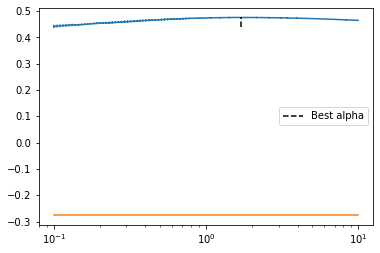

In [62]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(cv_res.param_alpha, cv_res.mean_test_score,
        [10**min_alpha_log, 10**max_alpha_log], [baseline_err, baseline_err])
ax.set_xscale('log')
ax.vlines(
    best_params["alpha"],
    cv_res.mean_test_score.min(),
    cv_res.mean_test_score.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


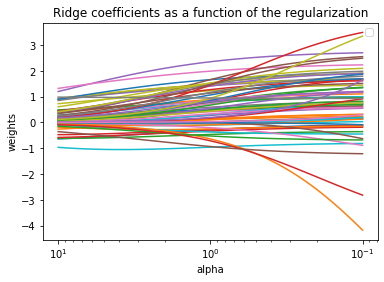

In [63]:
# cf. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html

import warnings
with warnings.catch_warnings():
    alphas = np.logspace(min_alpha_log, max_alpha_log, n_alphas)

    coefs = []
    for a in alphas:
        ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
        ridge.fit(X, y)
        coefs.append(ridge.coef_[0])

    #coefs = np.vstack(coefs)
    #flat_coefs = np.ravel(coefs)
    #display(coefs)


    ax = plt.gca()
    ax.plot(alphas, coefs)
    """ax.vlines(
        best_params["alpha"],
        #flat_coefs.min(),
        #flat_coefs.max(),
        color="black",
        linestyle="--",
        label="Best alpha",
    )"""

    ax.set_xscale("log")
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel("alpha")
    plt.ylabel("weights")
    plt.title("Ridge coefficients as a function of the regularization")
    plt.axis("tight")
    plt.legend()

    plt.show()

In [64]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
429,0.004999,0.000894,0.003000,6.322610e-04,1.707353,42,sparse_cg,"{'alpha': 1.7073526474706913, 'random_state': ...",0.433615,0.457491,0.521339,0.467065,0.501135,0.476129,0.031325,1
443,0.004800,0.000401,0.002802,3.994036e-04,1.873817,42,sparse_cg,"{'alpha': 1.873817422860385, 'random_state': 4...",0.433476,0.458626,0.520664,0.466385,0.501445,0.476119,0.031128,2
434,0.005002,0.000632,0.003399,1.019244e-03,1.78865,42,auto,"{'alpha': 1.7886495290574351, 'random_state': ...",0.433657,0.458010,0.521148,0.466362,0.501412,0.476118,0.031284,3
439,0.004401,0.000505,0.003392,7.933538e-04,1.78865,42,cholesky,"{'alpha': 1.7886495290574351, 'random_state': ...",0.433657,0.458010,0.521148,0.466362,0.501412,0.476118,0.031284,3
435,0.007601,0.000800,0.003399,4.896323e-04,1.78865,42,svd,"{'alpha': 1.7886495290574351, 'random_state': ...",0.433657,0.458010,0.521148,0.466362,0.501412,0.476118,0.031284,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,0.008401,0.000801,0.003800,3.991628e-04,0.104762,42,sparse_cg,"{'alpha': 0.10476157527896648, 'random_state':...",0.414412,0.428744,0.523218,0.453050,0.380625,0.440010,0.047754,696
5,0.005001,0.000634,0.003401,7.990948e-04,0.1,42,cholesky,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.416805,0.427554,0.521768,0.449443,0.381215,0.439357,0.046737,697
0,0.005399,0.001017,0.002999,2.786133e-06,0.1,42,auto,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.416805,0.427554,0.521768,0.449443,0.381215,0.439357,0.046737,697
1,0.006600,0.000800,0.003398,4.906242e-04,0.1,42,svd,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.416805,0.427554,0.521768,0.449443,0.381215,0.439357,0.046737,699


##### Recherche en grille intégrée

In [65]:
reg = linear_model.RidgeCV(alphas=np.logspace(-5, 15, 100)) #, store_cv_values=True)
reg.fit(X_train, y_train)

print('best', bold('alpha'), ':', reg.alpha_)
print('best', bold('n-MSE score'), ':', reg.best_score_)
print(' train', bold('r2 score'), ':', reg.score(X_train, y_train))
print('  test', bold('r2 score'), ':', reg.score(X_test, y_test))
print('global', bold('r2 score'), ':', reg.score(X, y))

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(reg, X, y, cv=3)

# display(reg.cv_values_)


best alpha : 0.7054802310718645
best n-MSE score : -1.0791014837927004
 train r2 score : 0.5403630941354294
  test r2 score : 0.5372163046110027
global r2 score : 0.5380067491594398
cv scores : [0.56444428 0.42538647 0.47240936]
mean scores : 0.4874133695330798
std scores : 0.057752971815575135


### Config 15 : second test d'intégration

$\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a) : \log(g)\}$

Gain significatif de 0,108491624 par rapport à la régression OLS.

$R^2_{15, \text{Ridge}} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(g)\}\right)$ :
* $\mu = 0.5561030913293757$
* $\sigma = 0.05809863786832774$

Rappels pour comparaison :

$R^2_{15, \text{OLS}} \left(\{t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a):\log(g)\}\right)$ :
* $\mu = $
* $\sigma = $

$R^2_{4, \text{OLS}} \left(\{\log(a):\log(e)\}\right)$:
* $\mu = $
* $\sigma = $

#### Jeu de données

In [72]:
config_name = "{t_p, T, (_a_u_k)_k, n_★, log(n_l), log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(data, config_name); # display(ml_data)

#### Vérifications

In [73]:
from seattle_commons import check_data
check_data(ml_data)

✘ Negative coefficients :


,ptype_Low-Rise Multifamily,ptype_Mid-Rise Multifamily,ptype_Small- and Mid-Sized Office,ptype_Other,ptype_Warehouse,ptype_Large Office,ptype_Mixed Use Property,ptype_High-Rise Multifamily,ptype_Retail Store,ptype_Hotel,...,_ua_Fast Food Restaurant,_ua_Swimming Pool,_ua_Outpatient Rehabilitation/Physical Therapy,_ua_Single Family Home,_ua_Energy/Power Station,_ua_Vocat,star_score,log(n_l),log(a),log(g)
id,,,,,,,,,,,,,,,,,,,,,
32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,-0.003151,0.000000,0.0,0.000000,0.0,62.0,2.197225,11.974620,12.455157
43,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,-1.376086,0.0,8.0,1.386294,13.111980,16.641106
100,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,96.0,1.791759,12.664465,11.841149
234,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,60.0,1.098612,10.825601,8.006368
238,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,73.0,1.098612,11.420042,12.076932
247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,55.5,1.098612,12.096040,11.476573
248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,60.0,1.098612,10.979172,10.217933
264,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,75.0,1.609438,11.615347,11.439387
265,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,85.0,2.079442,11.669476,12.540221


✔ No NA coefficient


#### Partition

In [74]:
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Entraînement

##### Recherche en grille externe

In [75]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    lr = linear_model.LinearRegression()
    lr_reg = lr.fit(X_train, y_train)
    baseline_err = cross_val_score(lr_reg, X_train, y_train, cv=5).mean()
    print(baseline_err)

-0.38790911619948376


In [76]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_commons import print_title, print_subtitle, bold
import time
from pepper_skl_commons import Dataset, get_baseline_err, search_best_params, get_best_params

Xy = X_train, X_test, y_train, y_test
model = linear_model.Ridge()
min_alpha_log = -1
max_alpha_log = 1
n_alphas = 100

param_grid = {
    'alpha': np.logspace(min_alpha_log, max_alpha_log, n_alphas),
    'solver': ['auto', 'svd', 'sparse_cg', 'sag', 'saga', 'cholesky', 'lsqr'], #, 'lbfgs'
    'random_state': [42]
}

best_estimator = best_params = best_score = best_index = scorer = cv_res = None
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    (
        best_estimator,
        best_params,
        best_score,
        best_index,
        scorer,
        cv_res
    ) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

coucoukookoo


In [77]:
import warnings
with warnings.catch_warnings():
    print('best', bold('estimator'), ':', best_estimator)
    print('best', bold('params'), ':', best_params)
    print('best', bold('score'), ':', best_score)
    print('best', bold('index'), ':', best_index)
    print(bold('scorer'), ':', scorer)

    print(' train', bold('score'), ':', best_estimator.score(X_train, y_train))
    print('  test', bold('score'), ':', best_estimator.score(X_test, y_test))
    print('global', bold('score'), ':', best_estimator.score(X, y))

    print('best', bold('estimator'), 'intercept :', best_estimator.intercept_)
    print('best', bold('estimator'), '    coefs :', best_estimator.coef_)

    from seattle_commons import show_ols_scores # TODO : à renommer
    show_ols_scores(best_estimator, X, y, cv=3)

best estimator : Ridge(alpha=3.1257158496882367, random_state=42, solver='lsqr')
best params : {'alpha': 3.1257158496882367, 'random_state': 42, 'solver': 'lsqr'}
best score : 0.525791172300638
best index : 524
scorer : <function _passthrough_scorer at 0x000001EE031CA790>
 train score : 0.5628149521254329
  test score : 0.5731654295766608
global score : 0.5707589441043347
best estimator intercept : -0.643803785246071
best estimator     coefs : [-5.88476876e-01 -1.52431525e-01  2.56831153e-02  3.99420939e-01
 -5.76122438e-01 -3.89709026e-01 -1.50646292e-01  1.88387076e-01
 -1.16677481e-01  3.12469152e-01  4.91949353e-02 -3.42491464e-01
  1.63884927e-01  9.89732058e-02  3.05337769e-02  4.00323710e-01
 -2.65785106e-01  4.92373276e-02  6.71460522e-02 -8.53614603e-04
  3.50851676e-01  1.58430718e-01  2.88657211e-01  6.64779890e-03
 -1.75662629e-01 -1.80051374e-01 -1.20368319e-01 -5.81000167e-01
  2.85555446e-01  2.74133980e-02 -1.54524510e-01  4.33123343e-01
  9.69381161e-02  7.77224238e-02

In [78]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
524,0.007200,0.000748,0.004000,8.932970e-04,3.125716,42,lsqr,"{'alpha': 3.1257158496882367, 'random_state': ...",0.503129,0.533077,0.582059,0.492619,0.518072,0.525791,0.031282,1
576,0.006199,0.001467,0.003400,8.007170e-04,4.534879,42,sparse_cg,"{'alpha': 4.5348785081285845, 'random_state': ...",0.505681,0.513769,0.586687,0.493565,0.529247,0.525790,0.032581,2
531,0.006799,0.001166,0.004201,3.981639e-04,3.274549,42,lsqr,"{'alpha': 3.27454916287773, 'random_state': 42...",0.503060,0.533213,0.581820,0.492575,0.518103,0.525754,0.031220,3
583,0.006600,0.001019,0.002999,5.001110e-07,4.75081,42,sparse_cg,"{'alpha': 4.750810162102798, 'random_state': 4...",0.505352,0.514743,0.586073,0.493449,0.529147,0.525753,0.032345,4
538,0.008202,0.000981,0.004196,9.830083e-04,3.430469,42,lsqr,"{'alpha': 3.4304692863149193, 'random_state': ...",0.502986,0.533351,0.581569,0.492527,0.518135,0.525714,0.031156,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,0.005200,0.000400,0.003401,4.896695e-04,0.104762,42,auto,"{'alpha': 0.10476157527896648, 'random_state':...",0.480185,0.428826,0.547382,0.477544,0.365995,0.459987,0.060265,696
12,0.005600,0.000489,0.003600,7.996921e-04,0.104762,42,cholesky,"{'alpha': 0.10476157527896648, 'random_state':...",0.480185,0.428826,0.547382,0.477544,0.365995,0.459987,0.060265,696
1,0.010400,0.000489,0.004800,7.482647e-04,0.1,42,svd,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.479624,0.428313,0.546282,0.476866,0.360385,0.458294,0.061688,698
5,0.004798,0.000978,0.002803,7.483095e-04,0.1,42,cholesky,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.479624,0.428313,0.546282,0.476866,0.360385,0.458294,0.061688,699


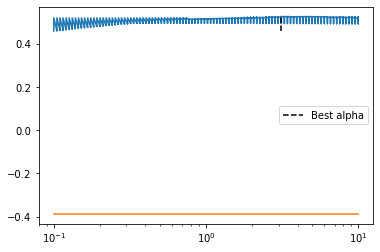

In [79]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(cv_res.param_alpha, cv_res.mean_test_score,
        [10**min_alpha_log, 10**max_alpha_log], [baseline_err, baseline_err])
ax.set_xscale('log')
ax.vlines(
    best_params["alpha"],
    cv_res.mean_test_score.min(),
    cv_res.mean_test_score.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


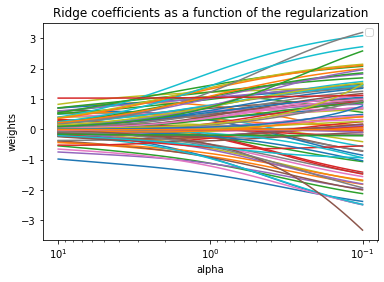

In [80]:
# cf. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html

import warnings
with warnings.catch_warnings():
    alphas = np.logspace(min_alpha_log, max_alpha_log, n_alphas)

    coefs = []
    for a in alphas:
        ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
        ridge.fit(X, y)
        coefs.append(ridge.coef_[0])

    #coefs = np.vstack(coefs)
    #flat_coefs = np.ravel(coefs)
    #display(coefs)


    ax = plt.gca()
    ax.plot(alphas, coefs)
    """ax.vlines(
        best_params["alpha"],
        #flat_coefs.min(),
        #flat_coefs.max(),
        color="black",
        linestyle="--",
        label="Best alpha",
    )"""

    ax.set_xscale("log")
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel("alpha")
    plt.ylabel("weights")
    plt.title("Ridge coefficients as a function of the regularization")
    plt.axis("tight")
    plt.legend()

    plt.show()

In [81]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
524,0.007200,0.000748,0.004000,8.932970e-04,3.125716,42,lsqr,"{'alpha': 3.1257158496882367, 'random_state': ...",0.503129,0.533077,0.582059,0.492619,0.518072,0.525791,0.031282,1
576,0.006199,0.001467,0.003400,8.007170e-04,4.534879,42,sparse_cg,"{'alpha': 4.5348785081285845, 'random_state': ...",0.505681,0.513769,0.586687,0.493565,0.529247,0.525790,0.032581,2
531,0.006799,0.001166,0.004201,3.981639e-04,3.274549,42,lsqr,"{'alpha': 3.27454916287773, 'random_state': 42...",0.503060,0.533213,0.581820,0.492575,0.518103,0.525754,0.031220,3
583,0.006600,0.001019,0.002999,5.001110e-07,4.75081,42,sparse_cg,"{'alpha': 4.750810162102798, 'random_state': 4...",0.505352,0.514743,0.586073,0.493449,0.529147,0.525753,0.032345,4
538,0.008202,0.000981,0.004196,9.830083e-04,3.430469,42,lsqr,"{'alpha': 3.4304692863149193, 'random_state': ...",0.502986,0.533351,0.581569,0.492527,0.518135,0.525714,0.031156,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,0.005200,0.000400,0.003401,4.896695e-04,0.104762,42,auto,"{'alpha': 0.10476157527896648, 'random_state':...",0.480185,0.428826,0.547382,0.477544,0.365995,0.459987,0.060265,696
12,0.005600,0.000489,0.003600,7.996921e-04,0.104762,42,cholesky,"{'alpha': 0.10476157527896648, 'random_state':...",0.480185,0.428826,0.547382,0.477544,0.365995,0.459987,0.060265,696
1,0.010400,0.000489,0.004800,7.482647e-04,0.1,42,svd,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.479624,0.428313,0.546282,0.476866,0.360385,0.458294,0.061688,698
5,0.004798,0.000978,0.002803,7.483095e-04,0.1,42,cholesky,"{'alpha': 0.1, 'random_state': 42, 'solver': '...",0.479624,0.428313,0.546282,0.476866,0.360385,0.458294,0.061688,699


##### Recherche en grille intégrée

In [82]:
reg = linear_model.RidgeCV(alphas=np.logspace(-5, 15, 100)) #, store_cv_values=True)
reg.fit(X_train, y_train)

print('best', bold('alpha'), ':', reg.alpha_)
print('best', bold('n-MSE score'), ':', reg.best_score_)
print(' train', bold('r2 score'), ':', reg.score(X_train, y_train))
print('  test', bold('r2 score'), ':', reg.score(X_test, y_test))
print('global', bold('r2 score'), ':', reg.score(X, y))

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(reg, X, y, cv=3)

# display(reg.cv_values_)


best alpha : 4.534878508128582
best n-MSE score : -0.9735939835109992
 train r2 score : 0.5807552853754576
  test r2 score : 0.591737321954191
global r2 score : 0.5891795704496208
cv scores : [0.63011448 0.48819573 0.54999906]
mean scores : 0.5561030913293757
std scores : 0.05809863786832774


## Config 18 : $\ln{g} = f(\ln{a}, \ln{n_l}, n_\star, (\tilde{a}_{u_k}), T, t_p, t_B)$

Config avec $t_b$ non abstrait ($t_B$) réduite au cas non résidentiel.

$\{t_B, t_p, T, \log(n_l), (\tilde{a}_{u_k}), n_\star, \log(a) : \log(g)\}$

$R^2_{18, \text{Ridge}} \left(\{t_B, t_p, T, (\tilde{a}_{u_k}), n_\star, \log(n_l), \log(a) : \log(g)\}\right)$ :
* $\mu = 0.5557078239278376$
* $\sigma = 0.055222365725657294$


#### Jeu de données

In [94]:
config_name = "{t_B, t_p, T, (_a_u_k)_k, n_★, log(n_l), log(a) : log(g)}"

from seattle_commons import get_ml_data_cfg
ml_data = get_ml_data_cfg(nr_data, config_name); display(ml_data)

,btype_NonResidential,btype_Nonresidential COS,btype_Campus,btype_SPS-District K-12,btype_Nonresidential WA,ptype_Small- and Mid-Sized Office,ptype_Other,ptype_Warehouse,ptype_Large Office,ptype_Mixed Use Property,...,_ua_Fast Food Restaurant,_ua_Swimming Pool,_ua_Outpatient Rehabilitation/Physical Therapy,_ua_Vocat,_ua_Single Family Home,_ua_Energy/Power Station,star_score,log(n_l),log(a),log(g)
id,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,60.0,2.564949,11.390012,12.429136
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,61.0,2.484907,11.547964,12.597642
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,43.0,3.737670,13.770628,14.552330
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,56.0,2.397895,11.023861,12.565249
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,75.0,2.944439,12.075850,13.132334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50221,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.693147,9.812523,9.919853
50223,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.693147,9.680344,10.378790
50224,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.693147,9.484709,12.317346


#### Visualisation

Trop de variables pour la visualisation.

In [95]:
from seattle_commons import check_data
check_data(ml_data)

✘ Negative coefficients :


,btype_NonResidential,btype_Nonresidential COS,btype_Campus,btype_SPS-District K-12,btype_Nonresidential WA,ptype_Small- and Mid-Sized Office,ptype_Other,ptype_Warehouse,ptype_Large Office,ptype_Mixed Use Property,...,_ua_Fast Food Restaurant,_ua_Swimming Pool,_ua_Outpatient Rehabilitation/Physical Therapy,_ua_Vocat,_ua_Single Family Home,_ua_Energy/Power Station,star_score,log(n_l),log(a),log(g)
id,,,,,,,,,,,,,,,,,,,,,
32,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.003151,0.000000,0.0,0.0,0.000000,62.5,2.197225,11.974620,12.455157
43,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.000000,0.000000,0.0,0.0,-1.376086,8.0,1.386294,13.111980,16.641106
100,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,96.0,1.791759,12.664465,11.841149
234,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,60.0,1.098612,10.825601,8.006368
238,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,73.0,1.098612,11.420042,12.076932
247,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,55.5,1.098612,12.096040,11.476573
248,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,60.0,1.098612,10.979172,10.217933
264,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,65.5,1.609438,11.615347,11.439387
267,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,62.5,0.000000,13.747544,14.309267


✔ No NA coefficient


#### Partition

In [96]:
from seattle_commons import features_target_split
X, y = features_target_split(ml_data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=42)

#### Entraînement

##### Recherche en grille externe

In [97]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    lr = linear_model.LinearRegression()
    lr_reg = lr.fit(X_train, y_train)
    baseline_err = cross_val_score(lr_reg, X_train, y_train, cv=5).mean()
    print(baseline_err)

-1.714891458681868e+17


In [98]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from pepper_commons import print_title, print_subtitle, bold
import time
from pepper_skl_commons import Dataset, get_baseline_err, search_best_params, get_best_params

Xy = X_train, X_test, y_train, y_test
model = linear_model.Ridge()
min_alpha_log = -1
max_alpha_log = 1
n_alphas = 100

param_grid = {
    'alpha': np.logspace(min_alpha_log, max_alpha_log, n_alphas),
    'solver': ['auto', 'svd', 'sparse_cg', 'sag', 'saga', 'cholesky', 'lsqr'], #, 'lbfgs'
    'random_state': [42]
}

best_estimator = best_params = best_score = best_index = scorer = cv_res = None
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    (
        best_estimator,
        best_params,
        best_score,
        best_index,
        scorer,
        cv_res
    ) = get_best_params(Xy, model, param_grid, baseline_err, cv=5, verbose=False)

coucoukookoo


In [99]:
import warnings
with warnings.catch_warnings():
    print('best', bold('estimator'), ':', best_estimator)
    print('best', bold('params'), ':', best_params)
    print('best', bold('score'), ':', best_score)
    print('best', bold('index'), ':', best_index)
    print(bold('scorer'), ':', scorer)

    print(' train', bold('score'), ':', best_estimator.score(X_train, y_train))
    print('  test', bold('score'), ':', best_estimator.score(X_test, y_test))
    print('global', bold('score'), ':', best_estimator.score(X, y))

    print('best', bold('estimator'), 'intercept :', best_estimator.intercept_)
    print('best', bold('estimator'), '    coefs :', best_estimator.coef_)

    from seattle_commons import show_ols_scores # TODO : à renommer
    show_ols_scores(best_estimator, X, y, cv=3)

best estimator : Ridge(alpha=7.924828983539178, random_state=42, solver='svd')
best params : {'alpha': 7.924828983539178, 'random_state': 42, 'solver': 'svd'}
best score : 0.5287872704578154
best index : 659
scorer : <function _passthrough_scorer at 0x000001EE031CA790>
 train score : 0.6227163487057581
  test score : 0.5420130018844345
global score : 0.5624967368857772
best estimator intercept : 0.9635561894528593
best estimator     coefs : [-3.35757316e-01  2.27215291e-02  3.13035787e-01 -3.44046958e-14
 -1.45308230e-14 -2.53240428e-01  1.44530214e-01 -7.10868884e-01
 -2.33724670e-01  1.39179642e-01 -7.98510745e-02  2.98407664e-01
 -2.37314224e-02 -2.27098837e-01  9.04963833e-02  3.43362929e-02
  2.45426827e-01 -4.03400783e-01 -4.16421677e-02  1.42566612e-02
  1.10400392e-01 -2.56334599e-01  2.97640976e-01  3.26719601e-01
  5.28498212e-01  1.38509619e-03 -9.67341554e-02 -2.01809122e-01
 -1.72606727e-01  2.00668662e-01  2.68061284e-01 -1.90617413e-01
  3.62002756e-01 -4.53206048e-02 -2

In [100]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
659,0.008600,0.000800,0.004600,0.000489,7.924829,42,svd,"{'alpha': 7.924828983539178, 'random_state': 4...",0.524851,0.529642,0.492089,0.508596,0.588758,0.528787,0.032763,1
663,0.005598,0.000487,0.004600,0.001019,7.924829,42,cholesky,"{'alpha': 7.924828983539178, 'random_state': 4...",0.524851,0.529642,0.492089,0.508596,0.588758,0.528787,0.032763,2
658,0.005200,0.000400,0.003799,0.000399,7.924829,42,auto,"{'alpha': 7.924828983539178, 'random_state': 4...",0.524851,0.529642,0.492089,0.508596,0.588758,0.528787,0.032763,2
666,0.009199,0.000980,0.004601,0.000489,8.302176,42,svd,"{'alpha': 8.302175681319747, 'random_state': 4...",0.524169,0.529057,0.494160,0.507486,0.589045,0.528783,0.032573,4
670,0.004800,0.000981,0.003999,0.000632,8.302176,42,cholesky,"{'alpha': 8.302175681319747, 'random_state': 4...",0.524169,0.529057,0.494160,0.507486,0.589045,0.528783,0.032573,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,0.007599,0.001357,0.004000,0.000895,0.114976,42,sparse_cg,"{'alpha': 0.11497569953977356, 'random_state':...",0.551503,0.505584,-0.134964,0.523262,0.416722,0.372422,0.257666,696
30,0.007597,0.001016,0.004001,0.000632,0.12045,42,sparse_cg,"{'alpha': 0.12045035402587821, 'random_state':...",0.551939,0.506108,-0.149017,0.523482,0.419291,0.370360,0.263436,697
16,0.008401,0.001200,0.004000,0.000896,0.10975,42,sparse_cg,"{'alpha': 0.10974987654930562, 'random_state':...",0.551073,0.510530,-0.164379,0.524881,0.414193,0.367260,0.269815,698
9,0.010999,0.004098,0.004600,0.000490,0.104762,42,sparse_cg,"{'alpha': 0.10476157527896648, 'random_state':...",0.550620,0.504578,-0.171764,0.522824,0.411705,0.363593,0.271710,699


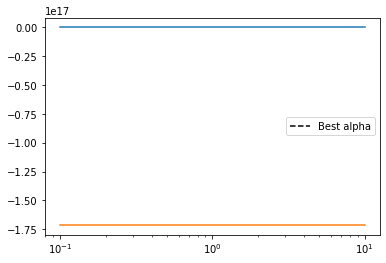

In [101]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(cv_res.param_alpha, cv_res.mean_test_score,
        [10**min_alpha_log, 10**max_alpha_log], [baseline_err, baseline_err])
ax.set_xscale('log')
ax.vlines(
    best_params["alpha"],
    cv_res.mean_test_score.min(),
    cv_res.mean_test_score.max(),
    color="black",
    linestyle="--",
    label="Best alpha",
)
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


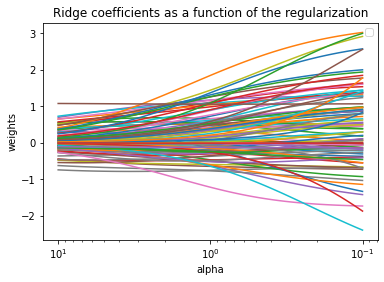

In [102]:
# cf. https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html

import warnings
with warnings.catch_warnings():
    alphas = np.logspace(min_alpha_log, max_alpha_log, n_alphas)

    coefs = []
    for a in alphas:
        ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
        ridge.fit(X, y)
        coefs.append(ridge.coef_[0])

    #coefs = np.vstack(coefs)
    #flat_coefs = np.ravel(coefs)
    #display(coefs)


    ax = plt.gca()
    ax.plot(alphas, coefs)
    """ax.vlines(
        best_params["alpha"],
        #flat_coefs.min(),
        #flat_coefs.max(),
        color="black",
        linestyle="--",
        label="Best alpha",
    )"""

    ax.set_xscale("log")
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    plt.xlabel("alpha")
    plt.ylabel("weights")
    plt.title("Ridge coefficients as a function of the regularization")
    plt.axis("tight")
    plt.legend()

    plt.show()

In [103]:
print_subtitle('Cross validated results :')  # TODO : mieux vaut un graphique + une sauvegarde
display(cv_res.sort_values(by='rank_test_score'))


Cross validated results :


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_random_state,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
659,0.008600,0.000800,0.004600,0.000489,7.924829,42,svd,"{'alpha': 7.924828983539178, 'random_state': 4...",0.524851,0.529642,0.492089,0.508596,0.588758,0.528787,0.032763,1
663,0.005598,0.000487,0.004600,0.001019,7.924829,42,cholesky,"{'alpha': 7.924828983539178, 'random_state': 4...",0.524851,0.529642,0.492089,0.508596,0.588758,0.528787,0.032763,2
658,0.005200,0.000400,0.003799,0.000399,7.924829,42,auto,"{'alpha': 7.924828983539178, 'random_state': 4...",0.524851,0.529642,0.492089,0.508596,0.588758,0.528787,0.032763,2
666,0.009199,0.000980,0.004601,0.000489,8.302176,42,svd,"{'alpha': 8.302175681319747, 'random_state': 4...",0.524169,0.529057,0.494160,0.507486,0.589045,0.528783,0.032573,4
670,0.004800,0.000981,0.003999,0.000632,8.302176,42,cholesky,"{'alpha': 8.302175681319747, 'random_state': 4...",0.524169,0.529057,0.494160,0.507486,0.589045,0.528783,0.032573,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23,0.007599,0.001357,0.004000,0.000895,0.114976,42,sparse_cg,"{'alpha': 0.11497569953977356, 'random_state':...",0.551503,0.505584,-0.134964,0.523262,0.416722,0.372422,0.257666,696
30,0.007597,0.001016,0.004001,0.000632,0.12045,42,sparse_cg,"{'alpha': 0.12045035402587821, 'random_state':...",0.551939,0.506108,-0.149017,0.523482,0.419291,0.370360,0.263436,697
16,0.008401,0.001200,0.004000,0.000896,0.10975,42,sparse_cg,"{'alpha': 0.10974987654930562, 'random_state':...",0.551073,0.510530,-0.164379,0.524881,0.414193,0.367260,0.269815,698
9,0.010999,0.004098,0.004600,0.000490,0.104762,42,sparse_cg,"{'alpha': 0.10476157527896648, 'random_state':...",0.550620,0.504578,-0.171764,0.522824,0.411705,0.363593,0.271710,699


##### Recherche en grille intégrée

In [104]:
reg = linear_model.RidgeCV(alphas=np.logspace(-5, 15, 100)) #, store_cv_values=True)
reg.fit(X_train, y_train)

print('best', bold('alpha'), ':', reg.alpha_)
print('best', bold('n-MSE score'), ':', reg.best_score_)
print(' train', bold('r2 score'), ':', reg.score(X_train, y_train))
print('  test', bold('r2 score'), ':', reg.score(X_test, y_test))
print('global', bold('r2 score'), ':', reg.score(X, y))

from seattle_commons import show_ols_scores # TODO : à renommer
show_ols_scores(reg, X, y, cv=3)

# display(reg.cv_values_)


best alpha : 4.534878508128582
best n-MSE score : -1.0495604257761748
 train r2 score : 0.6403735829058019
  test r2 score : 0.550847319002393
global r2 score : 0.5735704037732265
cv scores : [0.59635349 0.45573842 0.43343339]
mean scores : 0.49517510236403917
std scores : 0.0721210968851203
